### Based on the research that has already been done in ``model.ipynb`` I will create and evaluate a few models on a dataset without outliers.
### Because of the size of the dataset, it's difficult to train the model to handle outliers well.

### Preprocessing and importing modules

In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


In [2]:
cat_data = ["#e60049", "#0bb4ff", "#50e991", "#e6d800", "#9b19f5", "#ffa300", "#dc0ab4", "#b3d4ff", "#00bfa0"]

sns.set_theme(style='darkgrid', 
              palette=cat_data, 
              rc={"figure.dpi":600, 'savefig.dpi':600, 
                  "axes.spines.right": False, "axes.spines.top": False, 
                  'figure.figsize':(5,3.4), 'xtick.labelsize': 7.0, 'ytick.labelsize': 7.0
                  })

#### Remove outliers

In [3]:
df = pd.read_csv('clean_df.csv')
df = df.drop('price_per_sqm', axis=1)
df = df.sort_values(by='total_price')
df = df.iloc[250:-250]
df.reset_index(drop=True, inplace=True)

#### Prepare data

In [4]:
X = df.drop('total_price', axis=1)
Y = df['total_price']

In [5]:
onehot_features = ['b_type', 'district']
label_features = ['rooms', 'floor', 'built', 'max_floor']
binary_features = ['elevator', 'balcony', 'garden', 'terrace']
num_features = ['distance', 'area', 'rent']

In [6]:
onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_onehot = onehot_encoder.fit_transform(X[onehot_features])
X_onehot_df = pd.DataFrame(X_onehot, columns=onehot_encoder.get_feature_names_out(onehot_features))
X = X.drop(columns=onehot_features)
X = pd.concat([X, X_onehot_df], axis=1)

In [7]:
ordinal_encoder = OrdinalEncoder()
X[label_features] = ordinal_encoder.fit_transform(X[label_features])

In [8]:
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(Y.values.reshape(-1, 1))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Linear Regression

In [18]:
def coef_plot(model):
    coefficients = model.coef_
    feature_names = X.columns

    features_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

    features_df['Absolute Coefficient'] = features_df['Coefficient'].abs()
    features_df = features_df.sort_values(by='Absolute Coefficient', ascending=False)

    sns.barplot(x='Coefficient', y='Feature', data=features_df, hue='Feature', palette='rocket');
    plt.xlabel('Coefficient', fontsize=8);
    plt.ylabel('Feature', fontsize=8);
    plt.yticks(fontsize=4);

##### Training

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##### Evaluating the results

In [17]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 213704.82419916763
MSE: 124225930474.904
RMSE: 352456.9909576259
R²: 0.7489847425925041


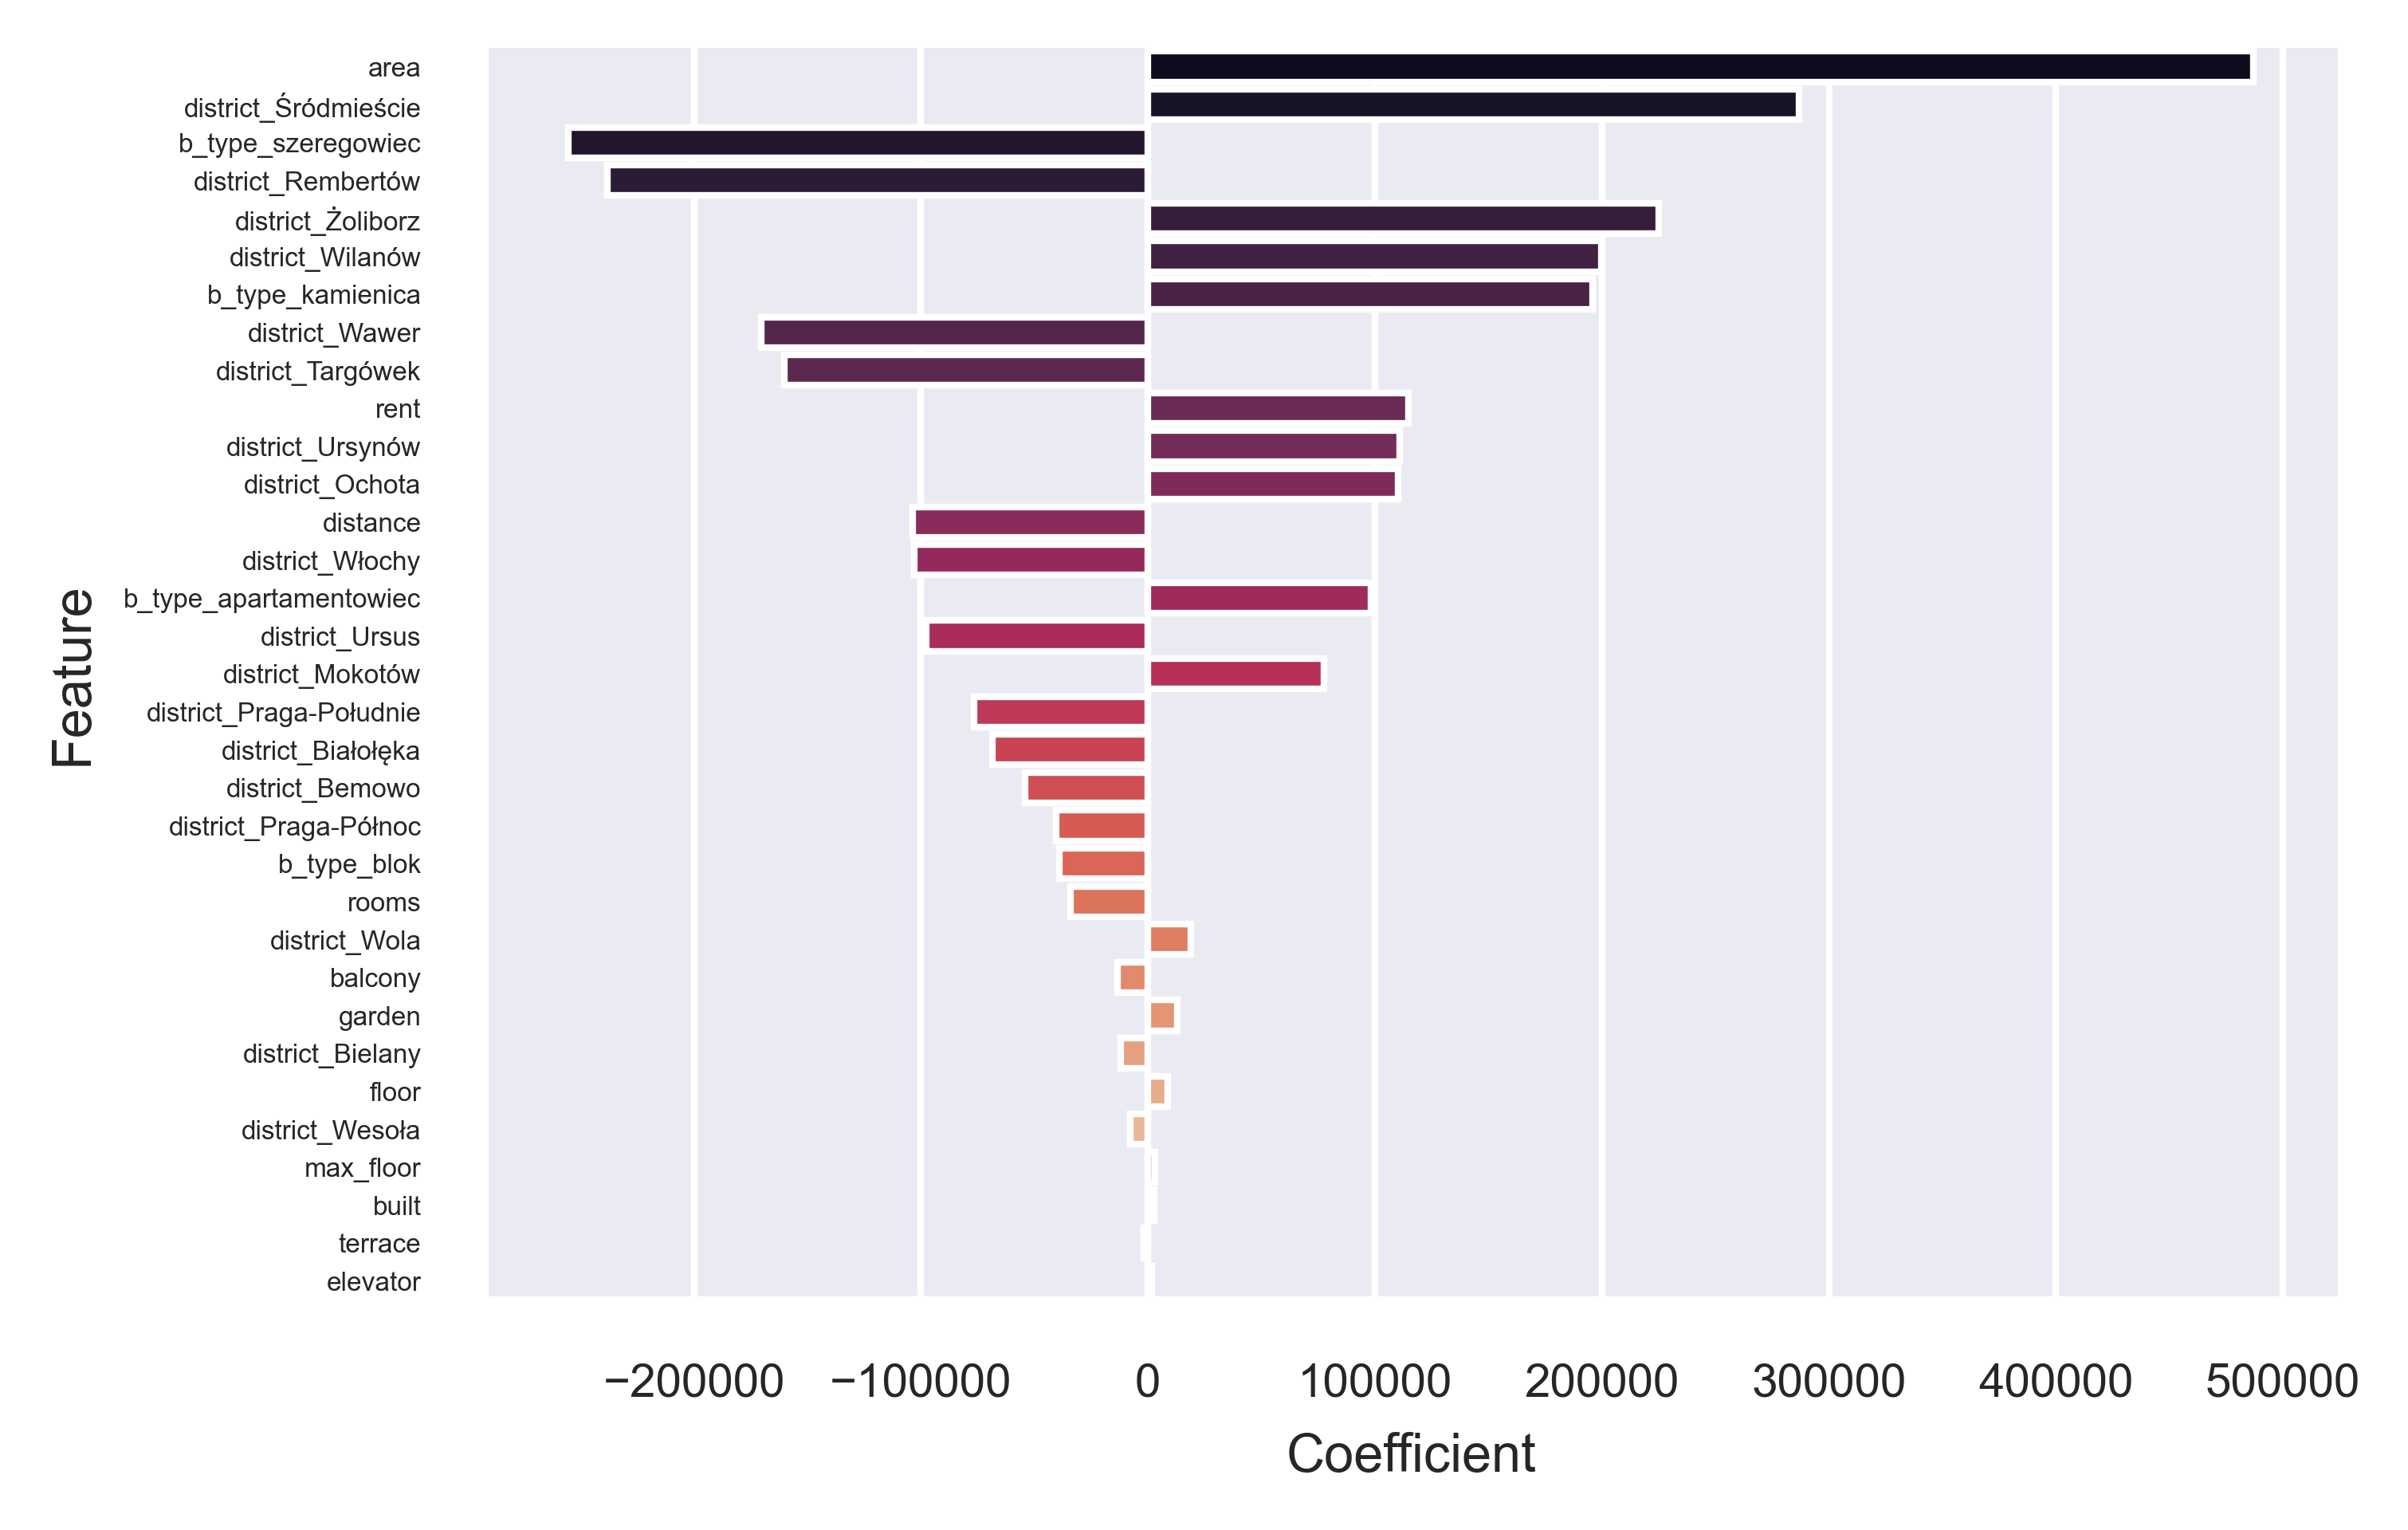

In [19]:
coef_plot(model)

### Ridge Regression

##### Training

In [20]:
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##### Evaluating

In [21]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 213685.44901133582
MSE: 124227772911.14626
RMSE: 352459.6046515774
R²: 0.748981019701431


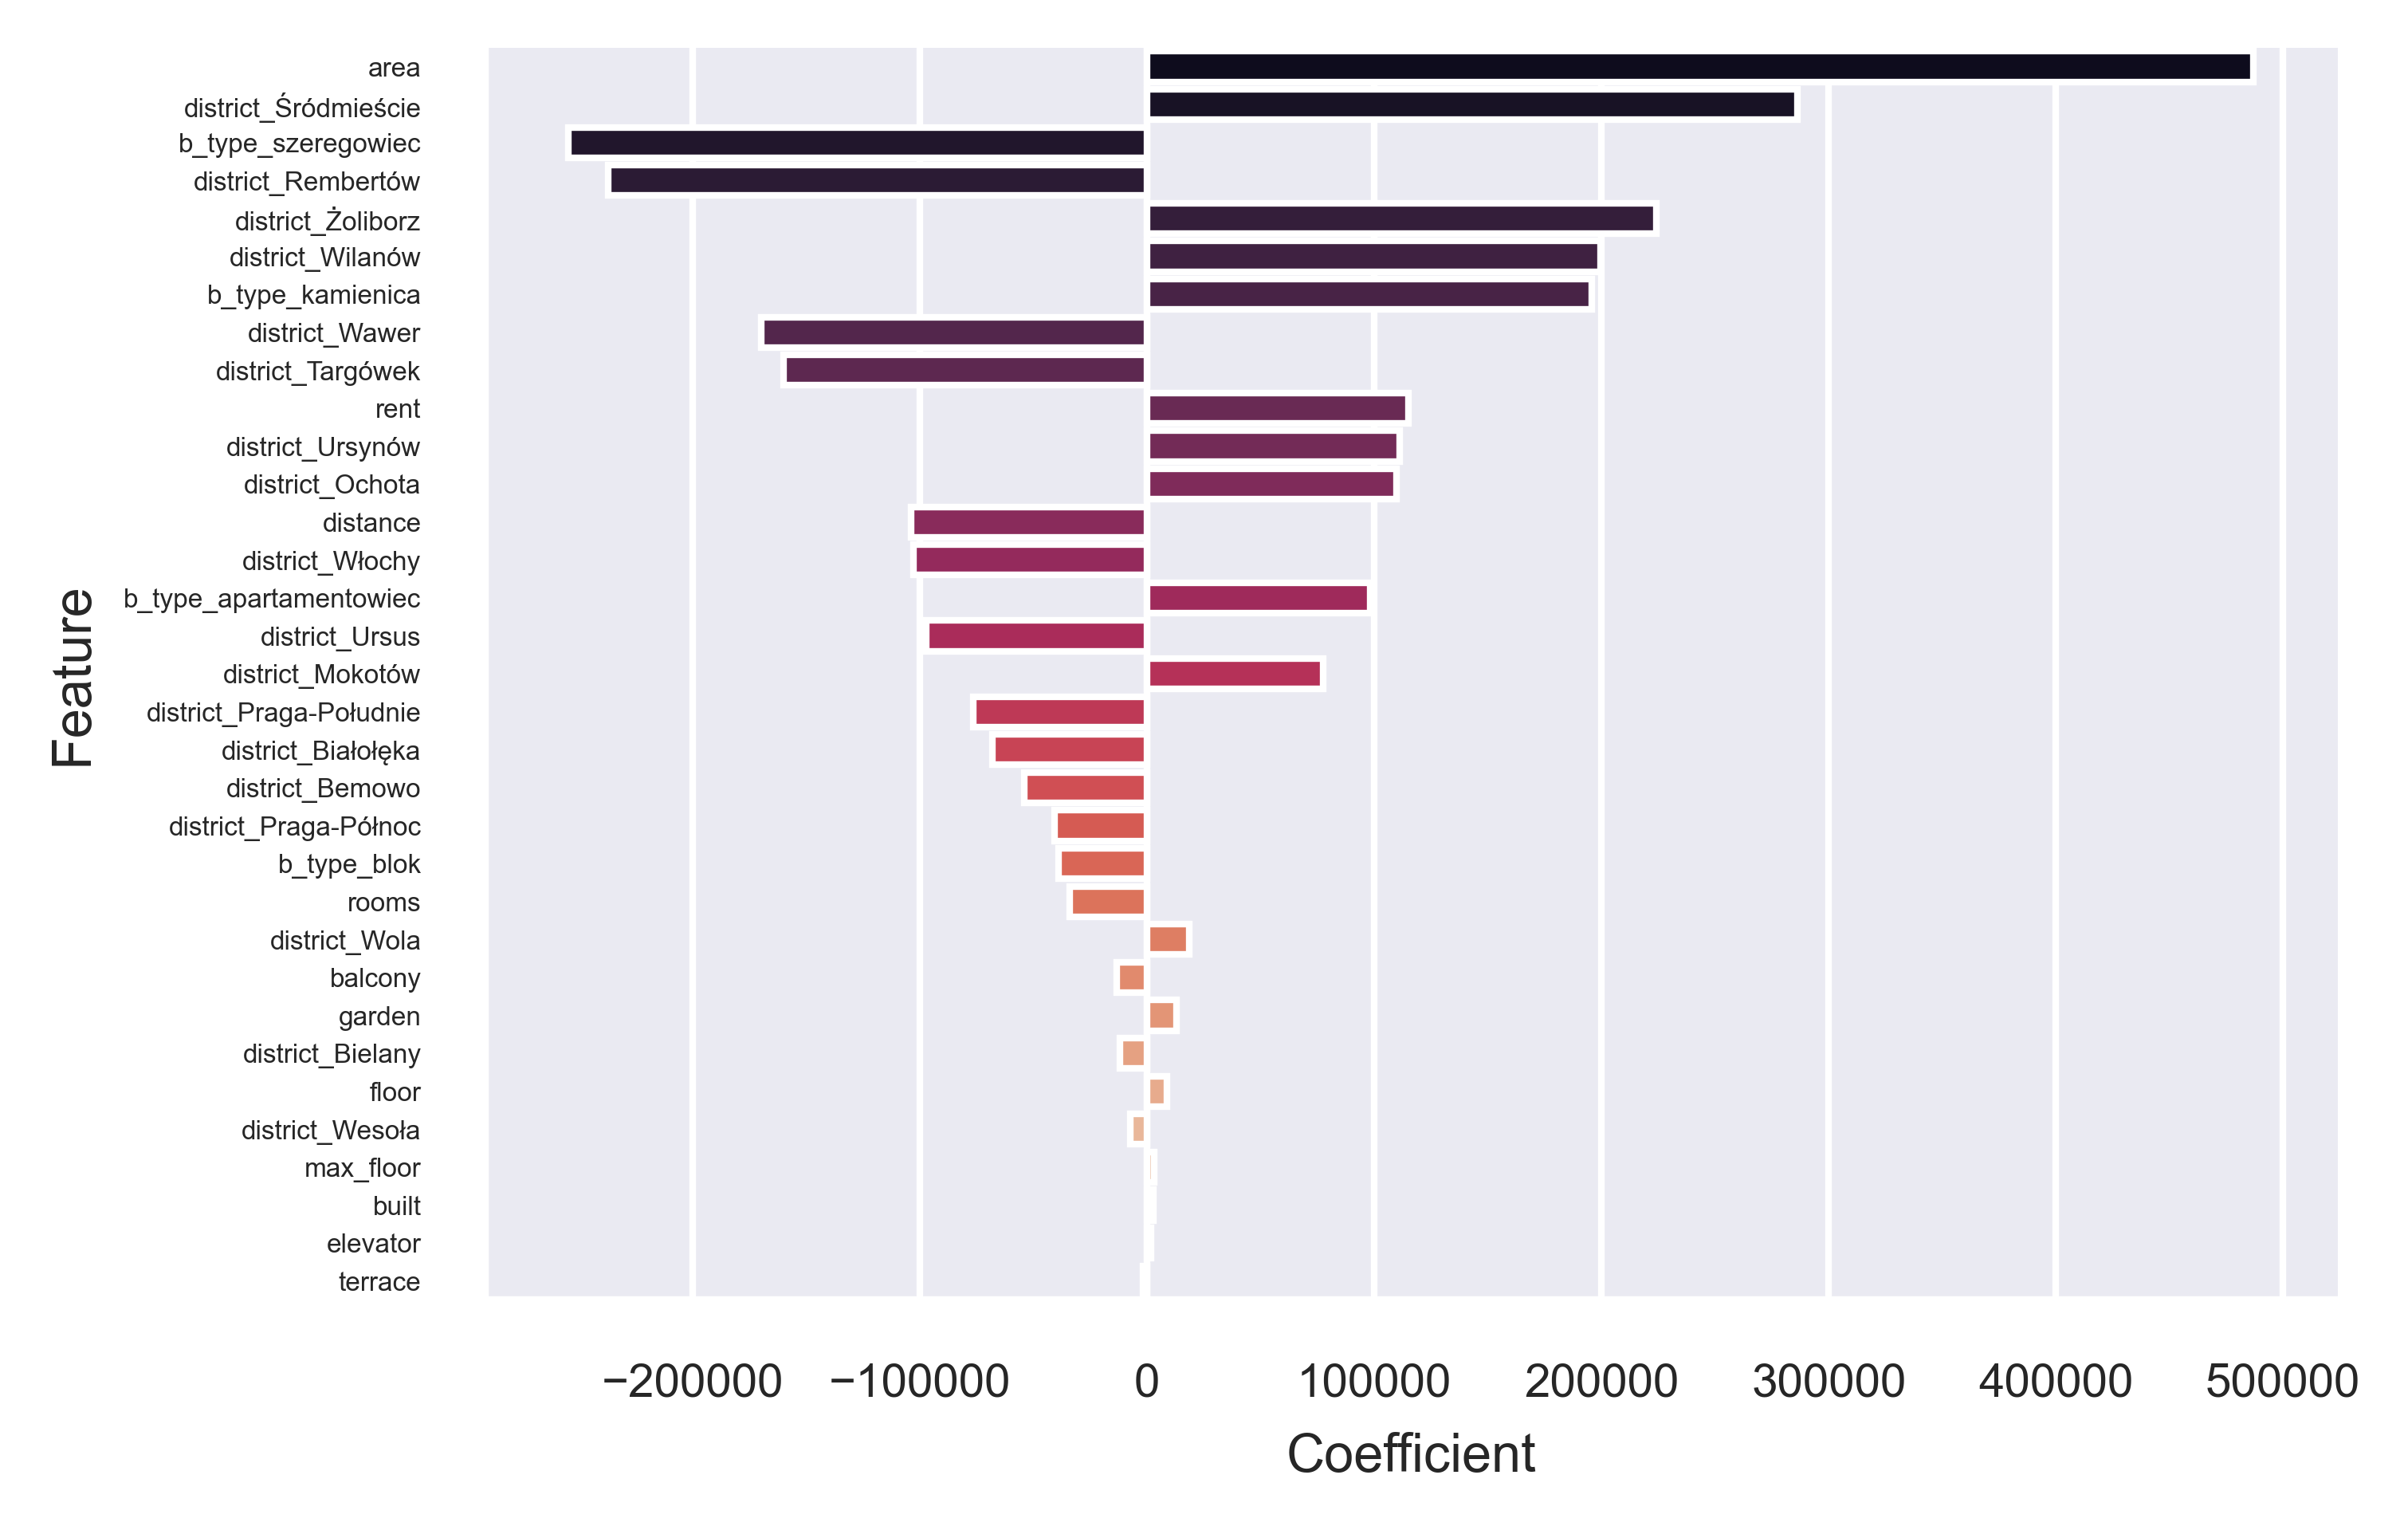

In [22]:
coef_plot(model)

### Lasso Regression

##### Training

In [26]:
model = Lasso(alpha=1, max_iter=1000, tol=0.1)
model.fit(X_train, y_train);
y_pred = model.predict(X_test)

##### Evaluating

In [27]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 213702.0120470125
MSE: 124226094985.69762
RMSE: 352457.2243346668
R²: 0.7489844101762442


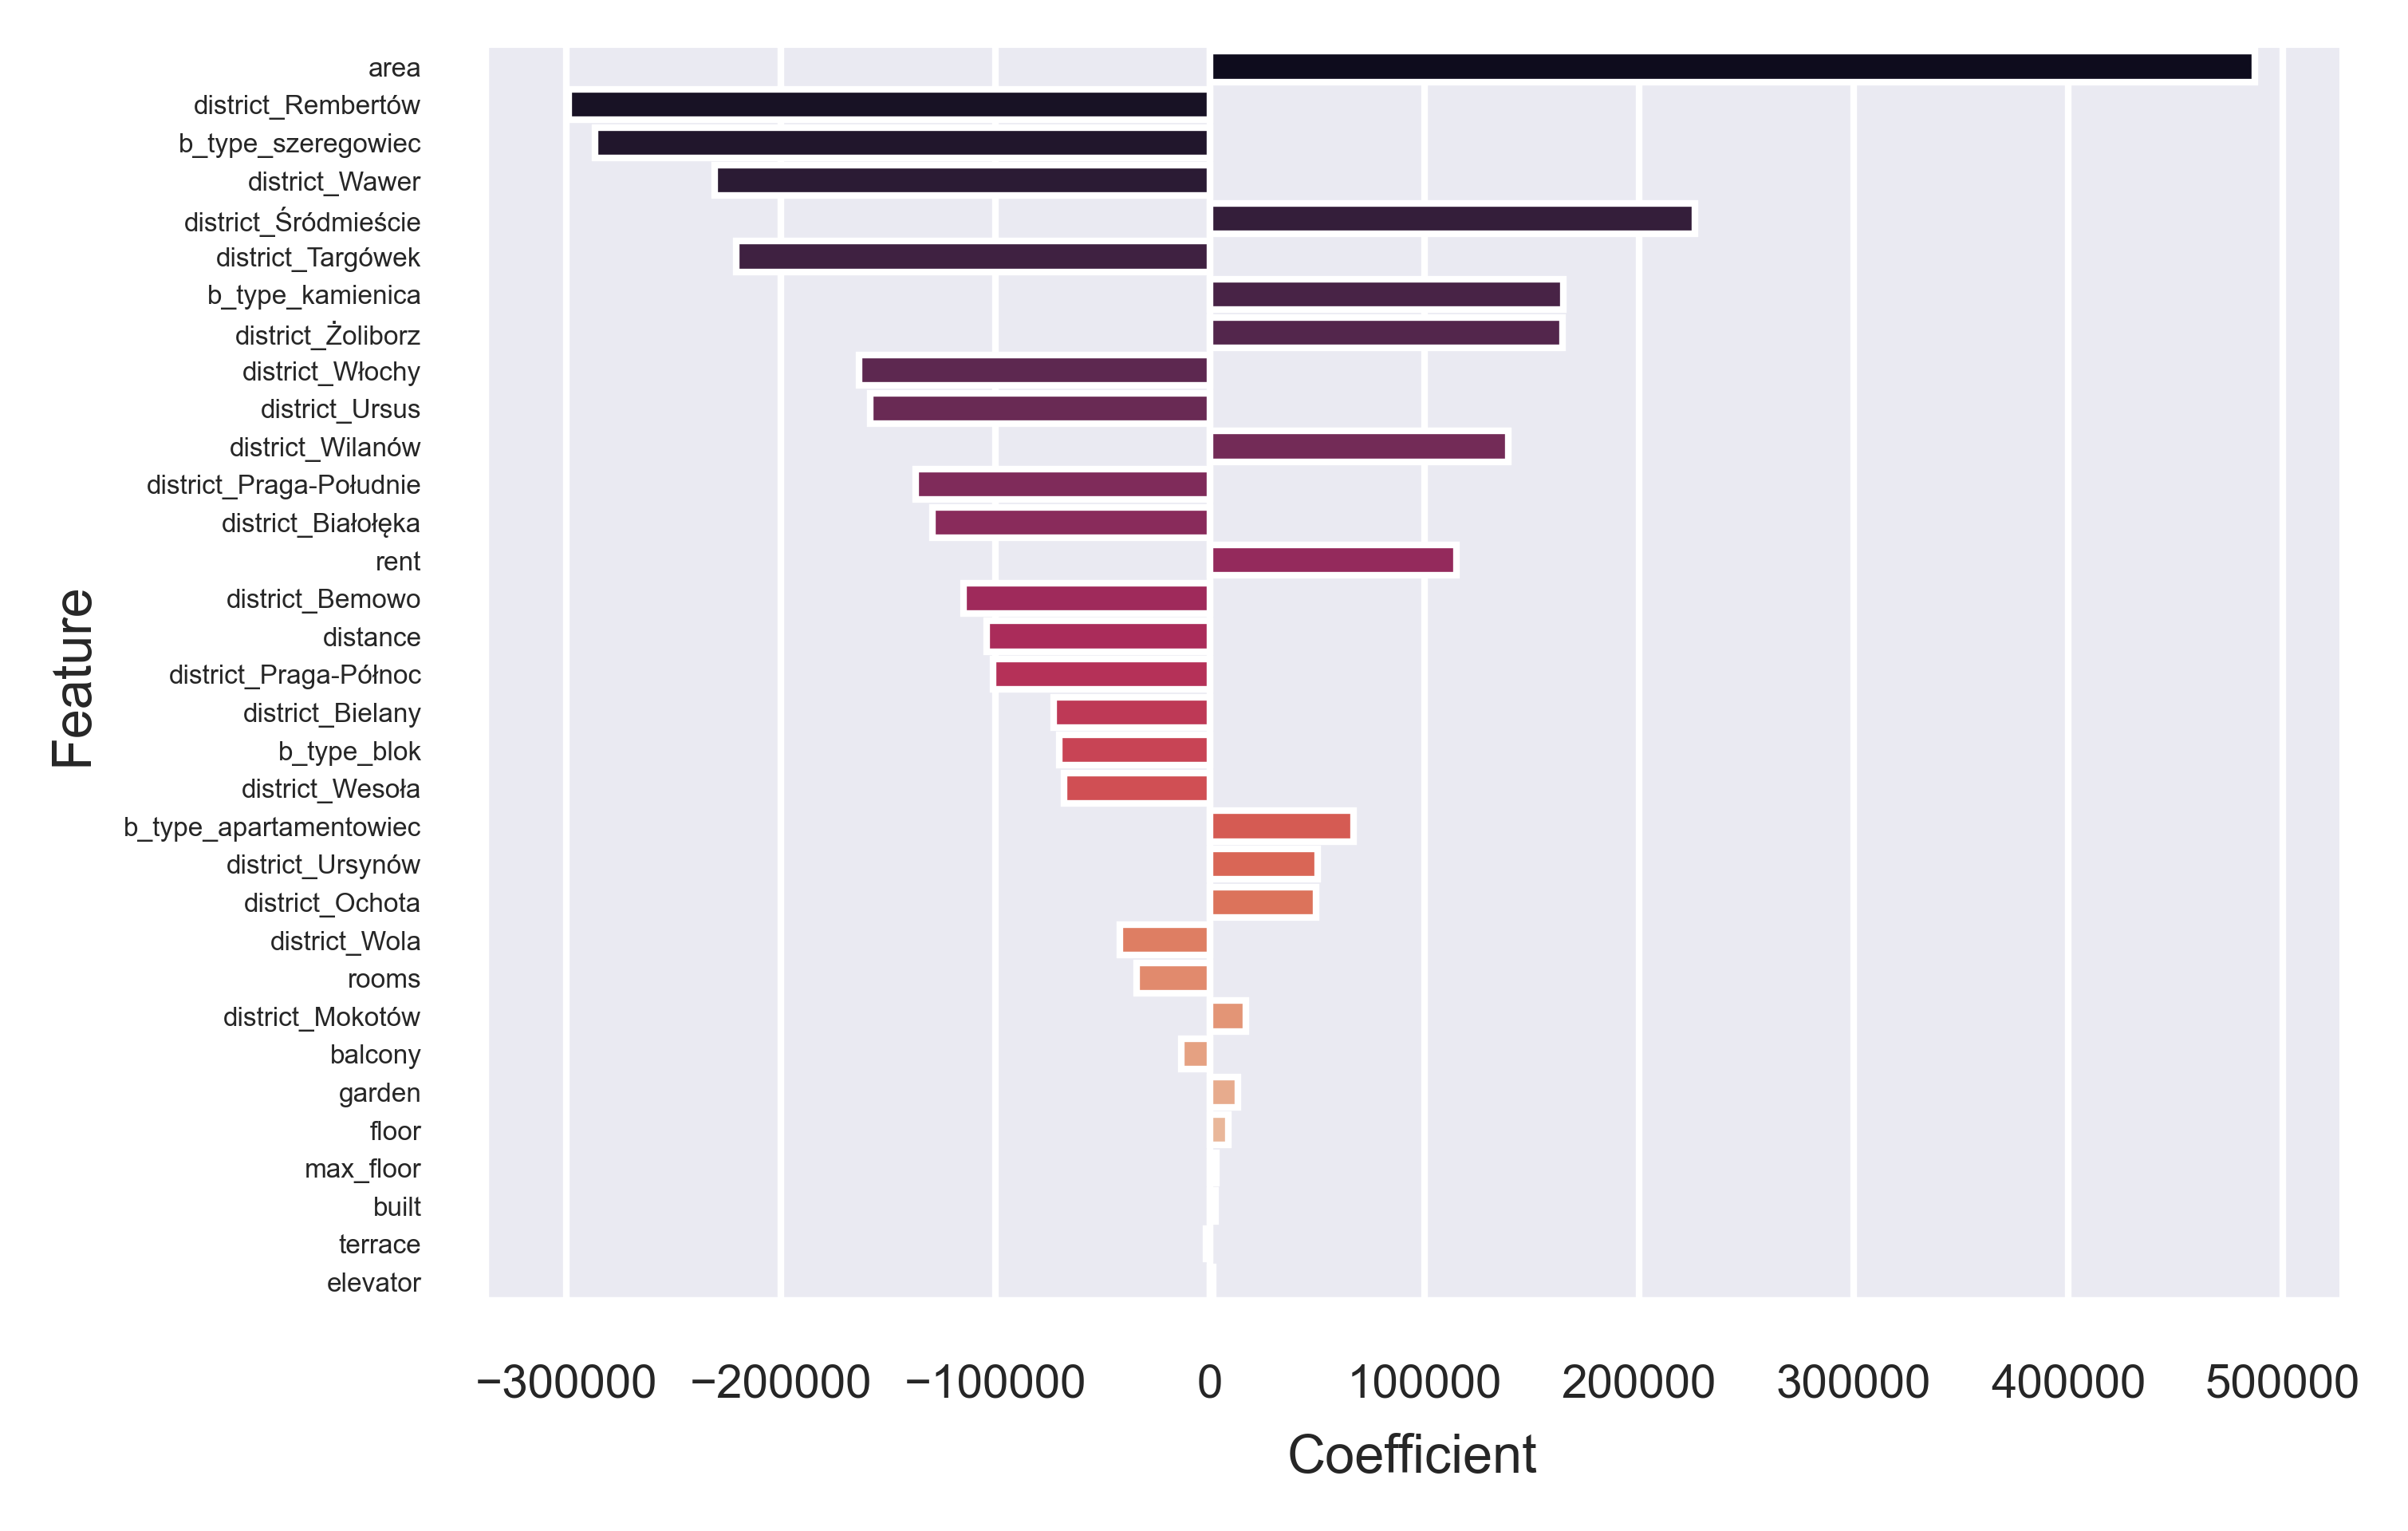

In [29]:
coef_plot(model)

### ElasticNet with GridSearch

##### Training

In [10]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}
grid_search = GridSearchCV(ElasticNet(tol=0.001, max_iter=10000), param_grid, cv=5)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e+14, tolerance: 9.497e+12
  model = cd_fast.enet_coordinate_descent(
/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.522e+14, tolerance: 9.570e+12
  model = cd_fast.enet_coordinate_descent(
/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did no

##### Evaluation

In [35]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 213413.62841569216
MSE: 124221385984.41925
RMSE: 352450.5440262779
R²: 0.7489939253488294


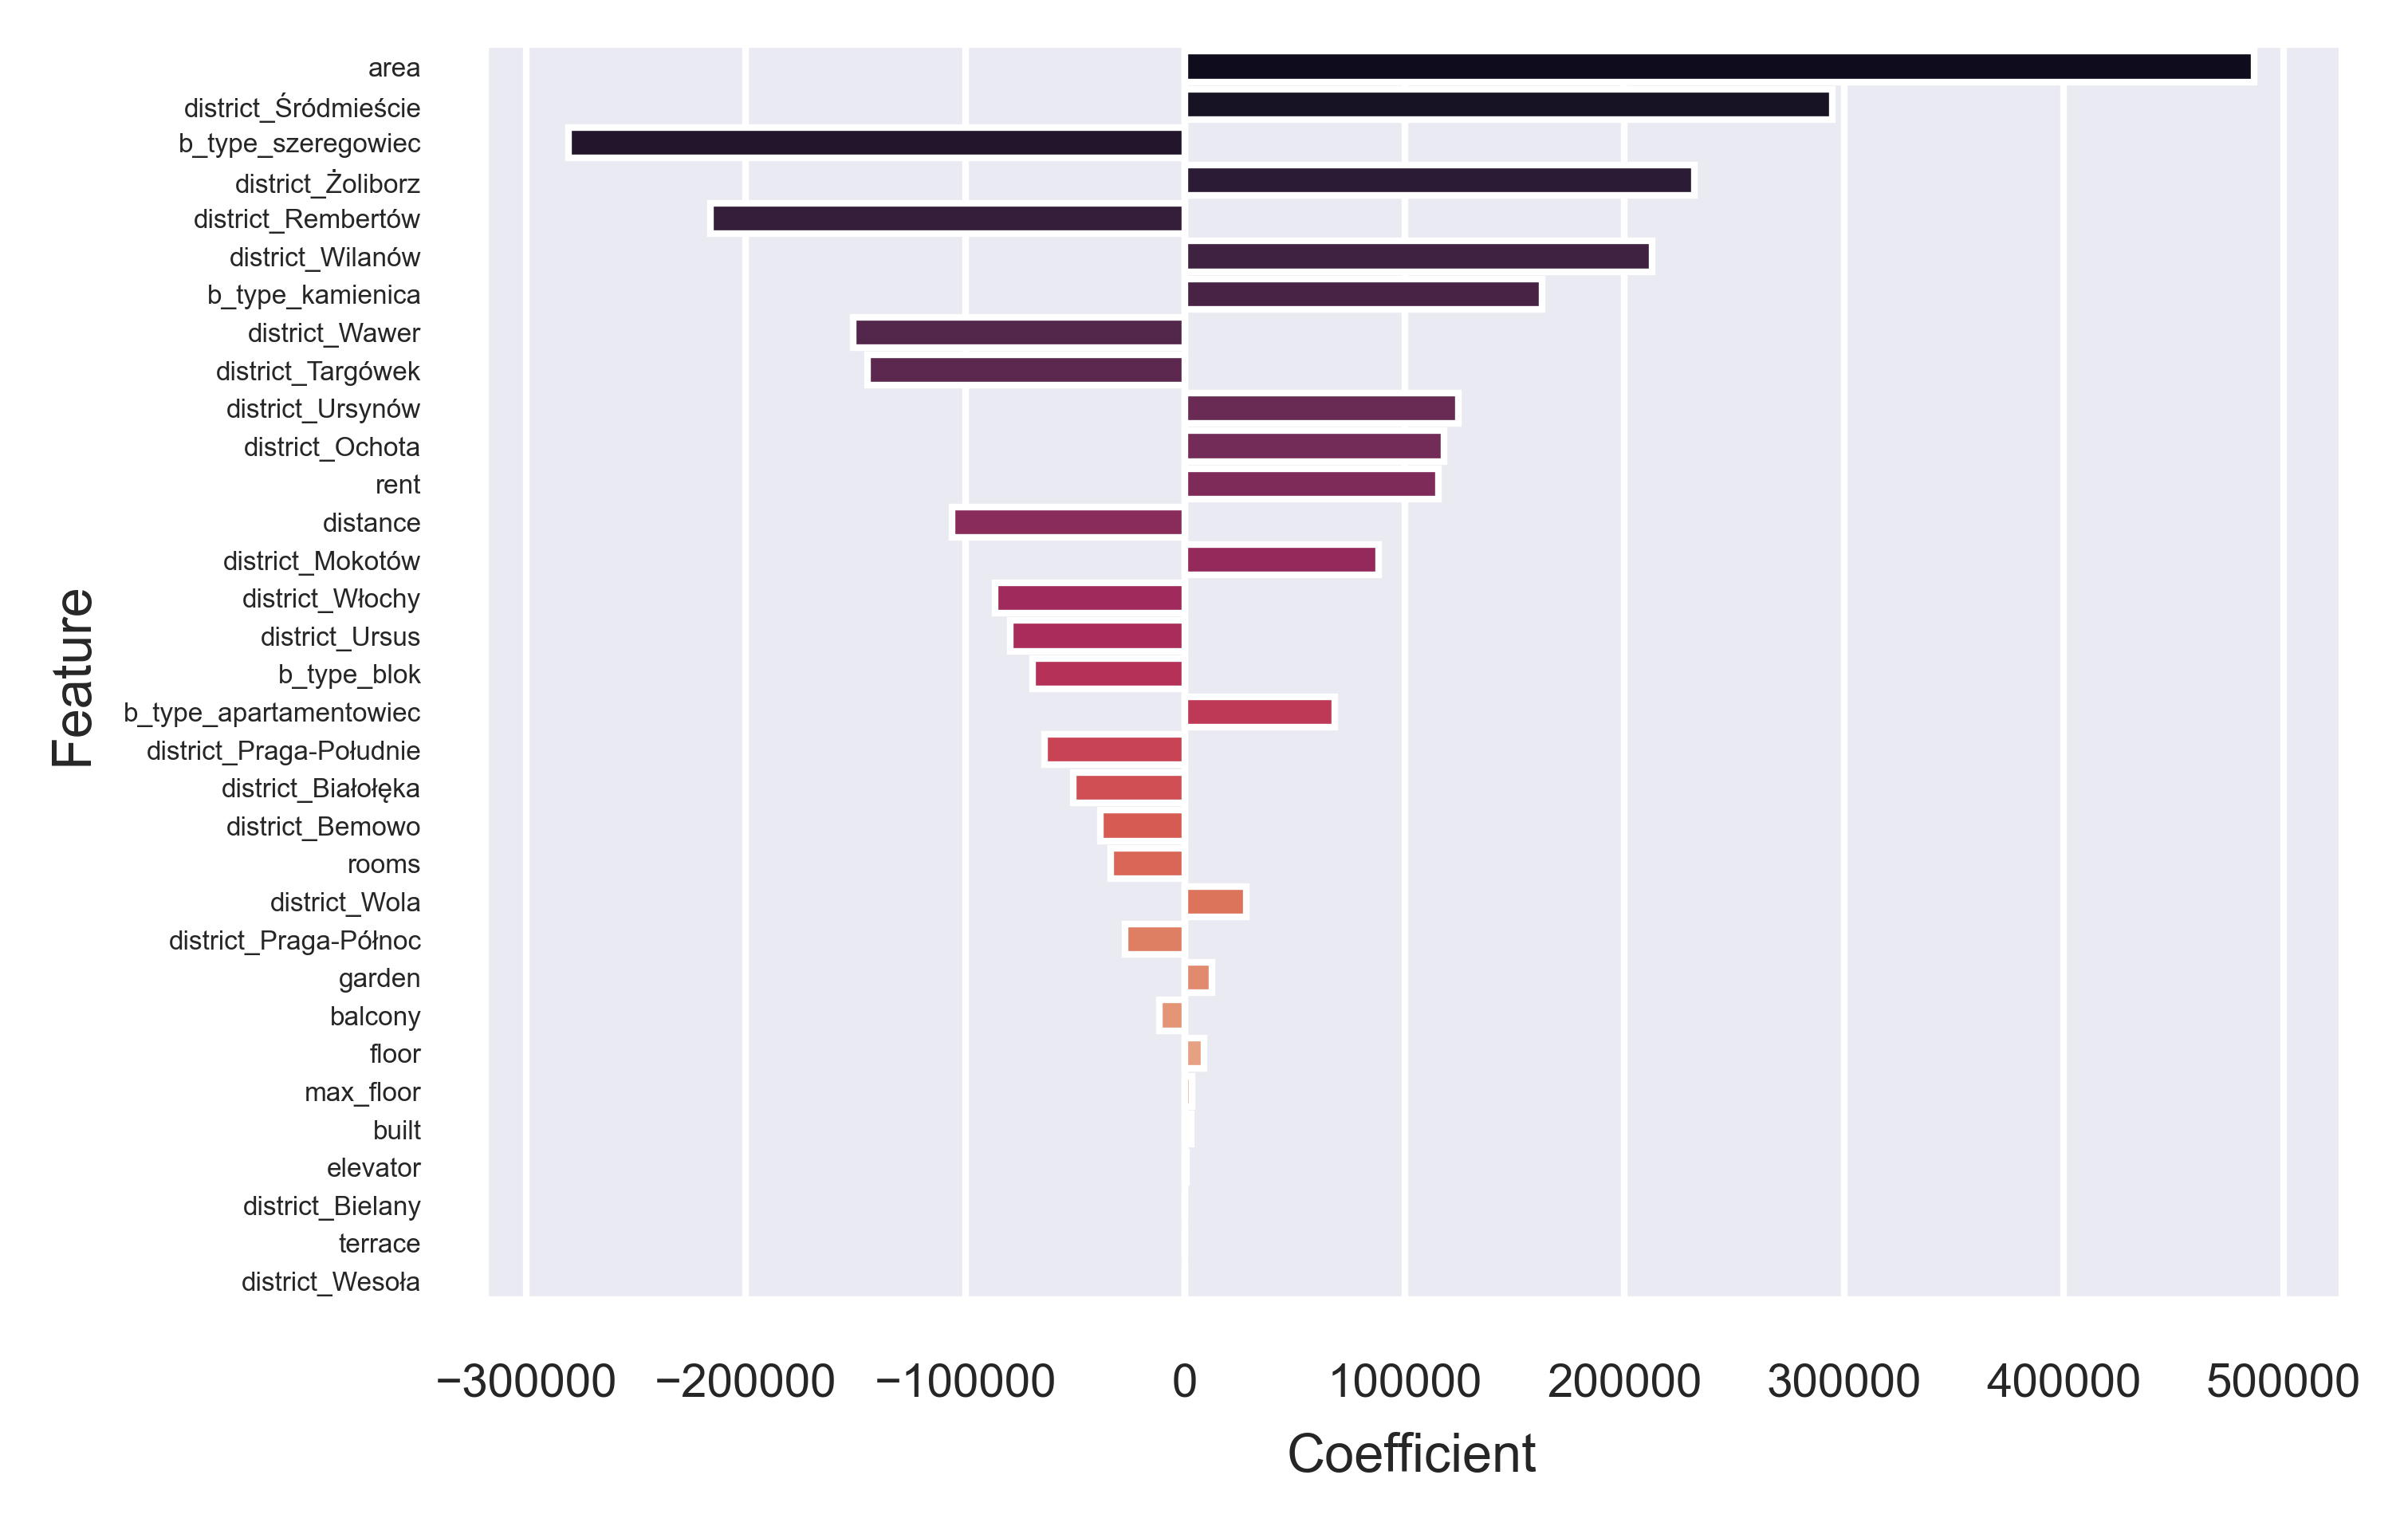

In [36]:
coef_plot(model)

### 2nd degree Polynomial Regression

##### Creating new features and splitting the data

In [11]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42)

##### Linear Regression 

Training

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Evaluating and Cross Validation

In [45]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 175419.16232383295
MSE: 81037210690.86223
RMSE: 284670.3544292279
R²: 0.83625337944028


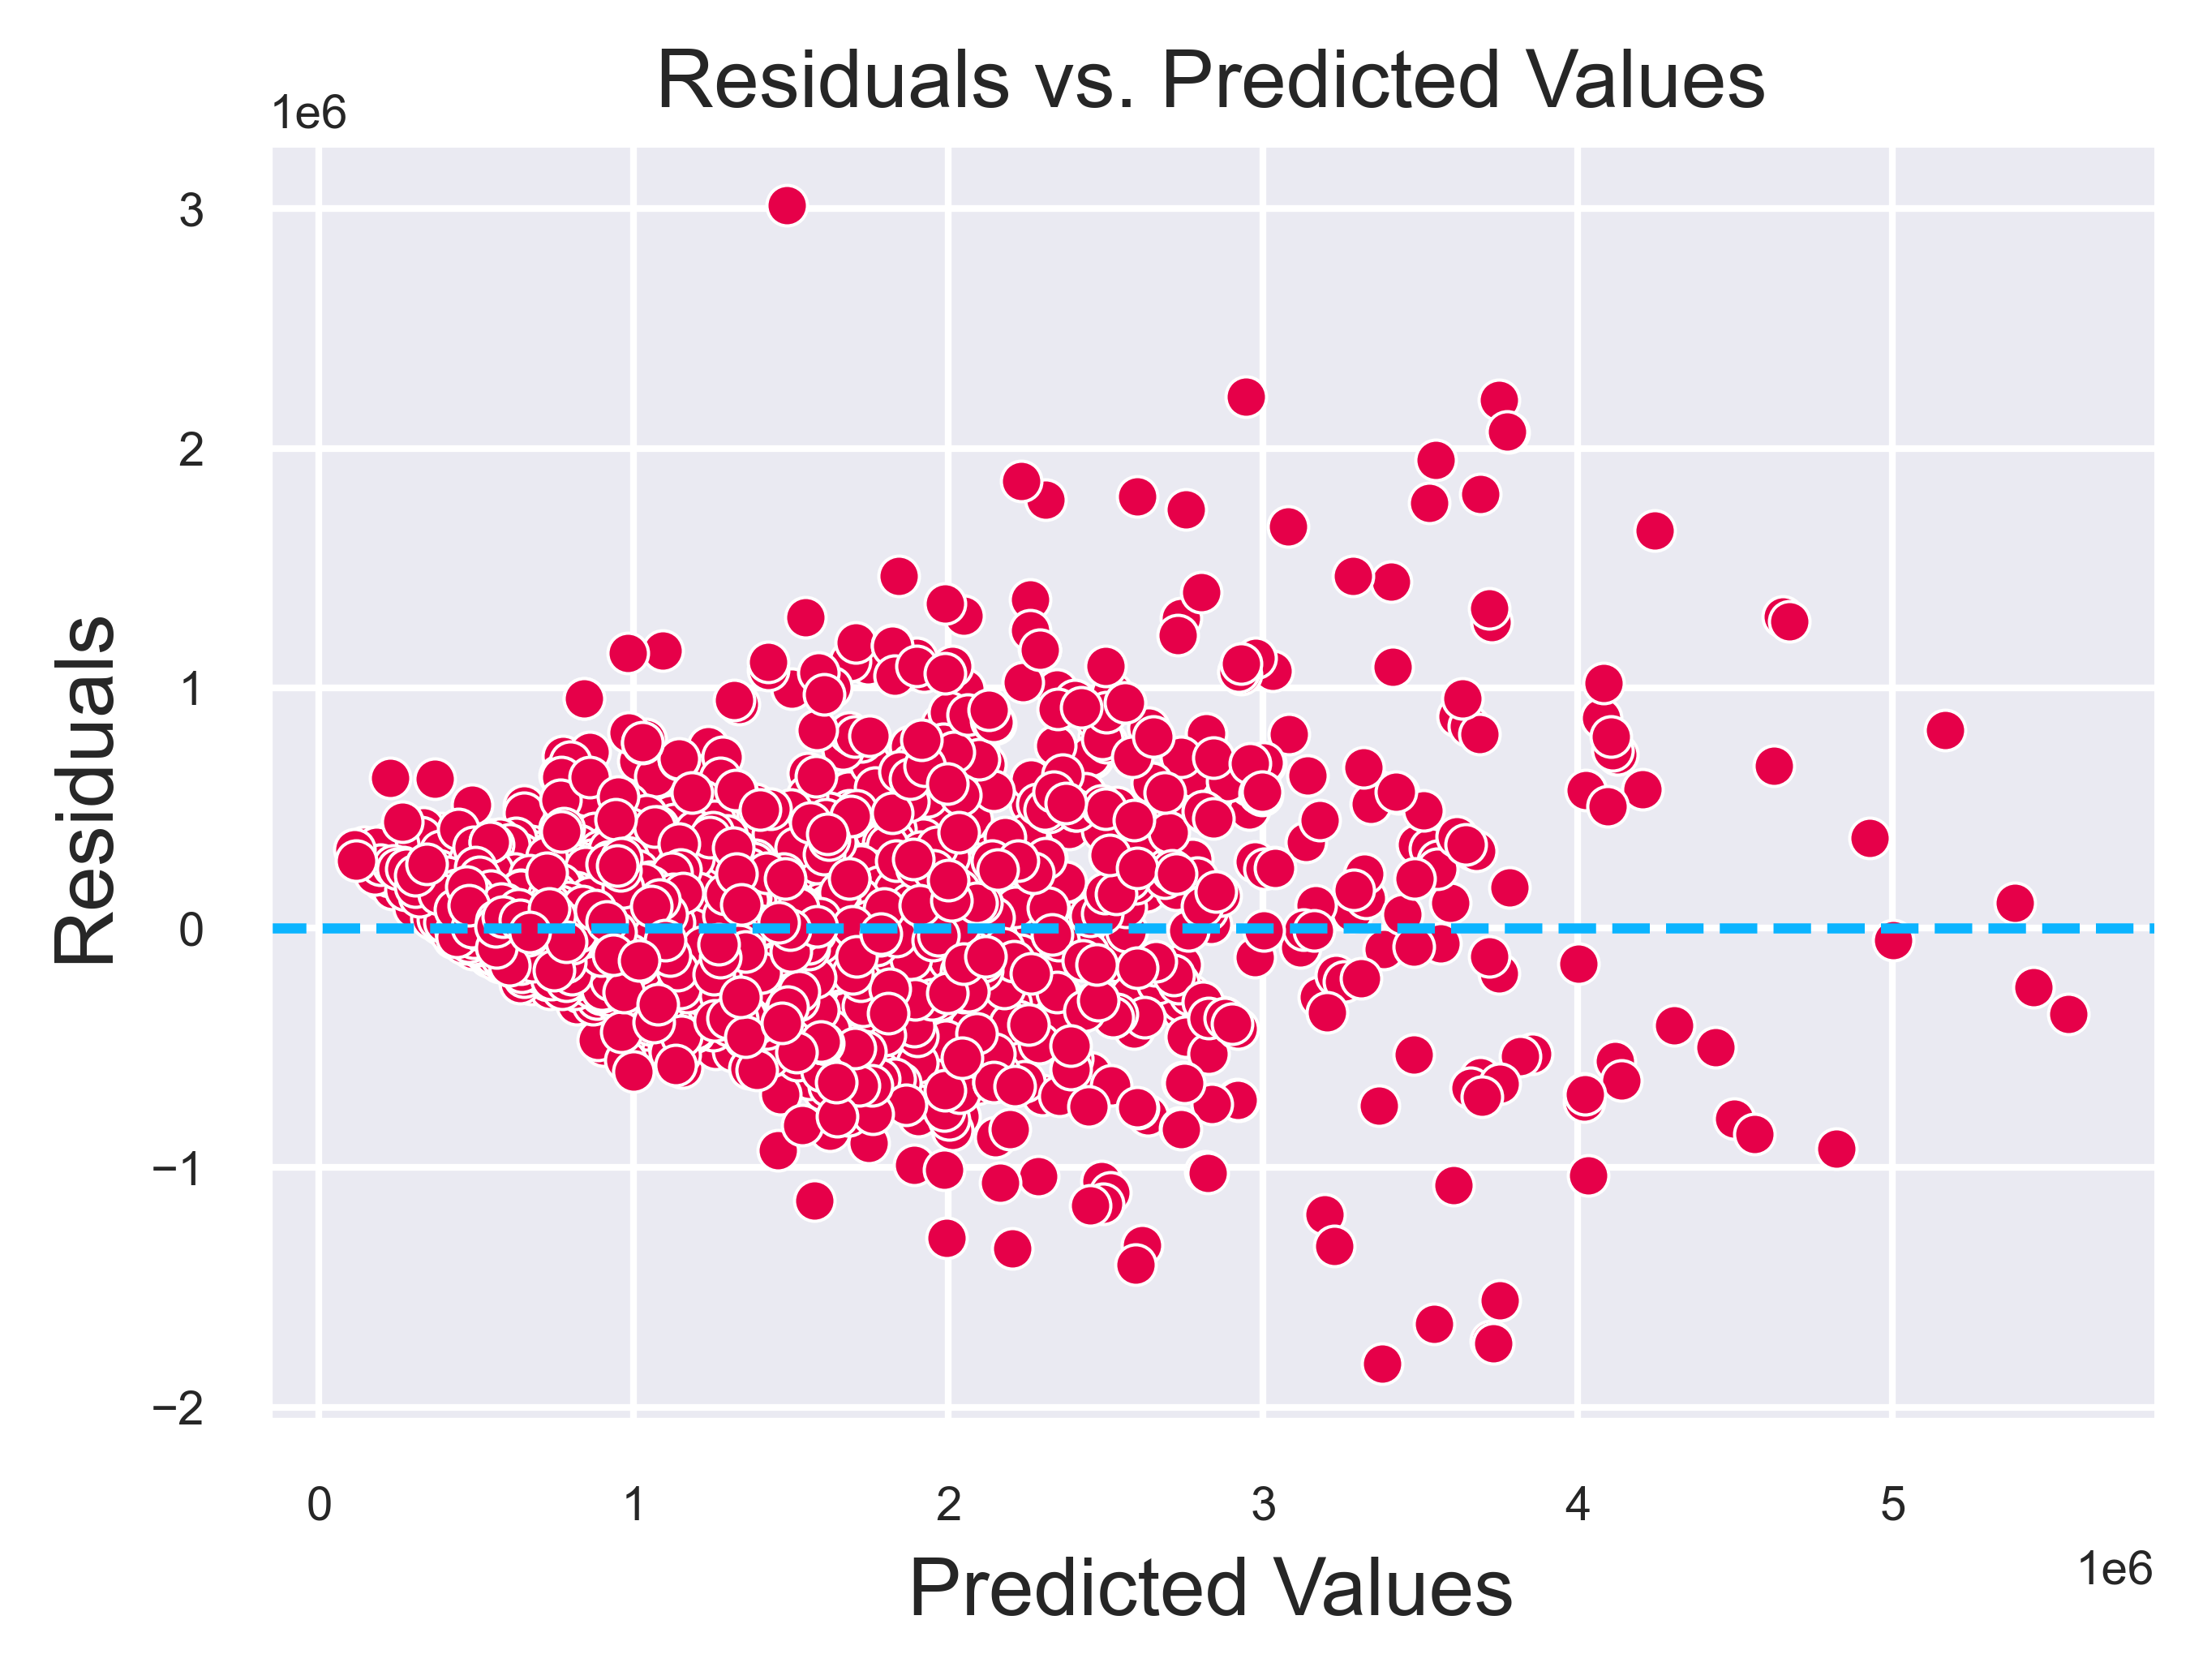

In [46]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [47]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LinearRegression(), X_poly, Y, cv=kf, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

Cross-Validation R² Scores: [0.83625568 0.82961105 0.83131323 0.82719818 0.83981048]
Mean Cross-Validation R² Score: 0.8328377213661324
Standard Deviation of Cross-Validation R² Scores: 0.004579119107084166


#### Ridge Regression

Training

In [48]:
model = Ridge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Evaluating and Cross Validation

In [49]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 175302.10853888627
MSE: 80995360301.71964
RMSE: 284596.83817941416
R²: 0.8363379437994527


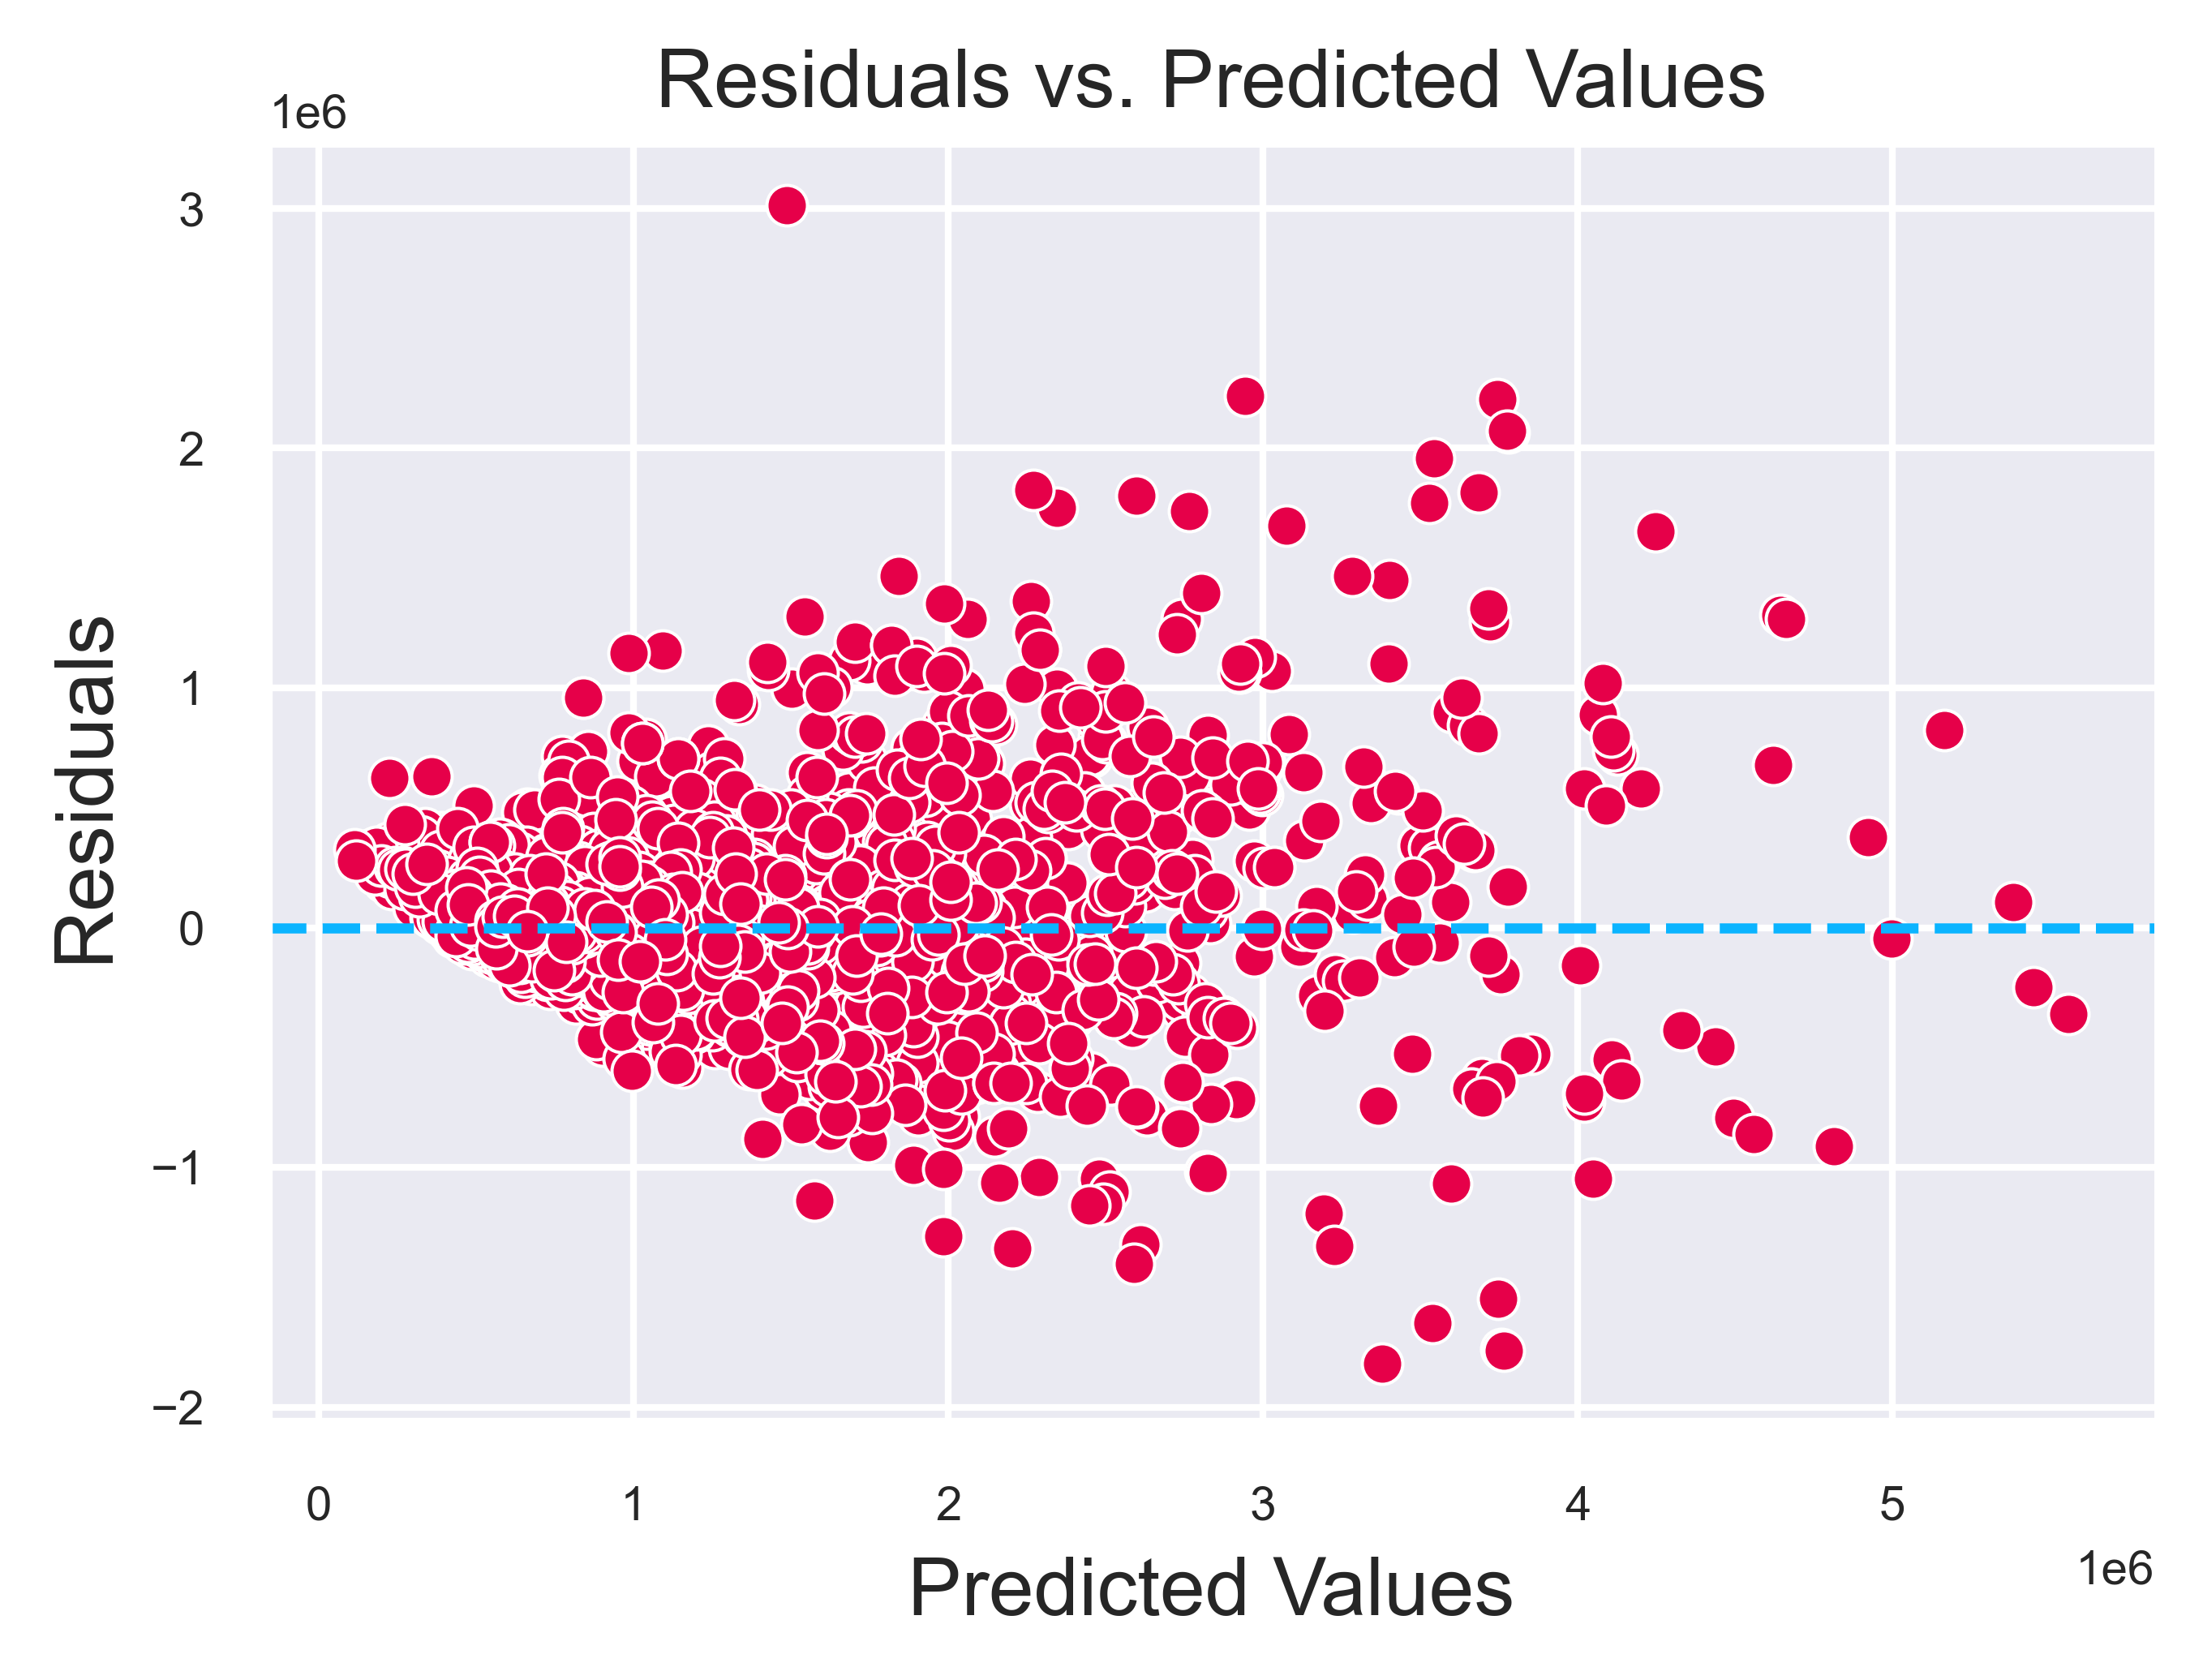

In [50]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [51]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(Ridge(), X_poly, Y, cv=kf, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

Cross-Validation R² Scores: [0.83633794 0.82986827 0.83086837 0.82724198 0.84016575]
Mean Cross-Validation R² Score: 0.832896461490891
Standard Deviation of Cross-Validation R² Scores: 0.004689193688590963


#### Lasso Regression

Training

In [54]:
model = Lasso(tol=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Evaluating and Cross Validation

In [55]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 179615.80172350322
MSE: 87752483450.26347
RMSE: 296230.45665539434
R²: 0.8226842645717609


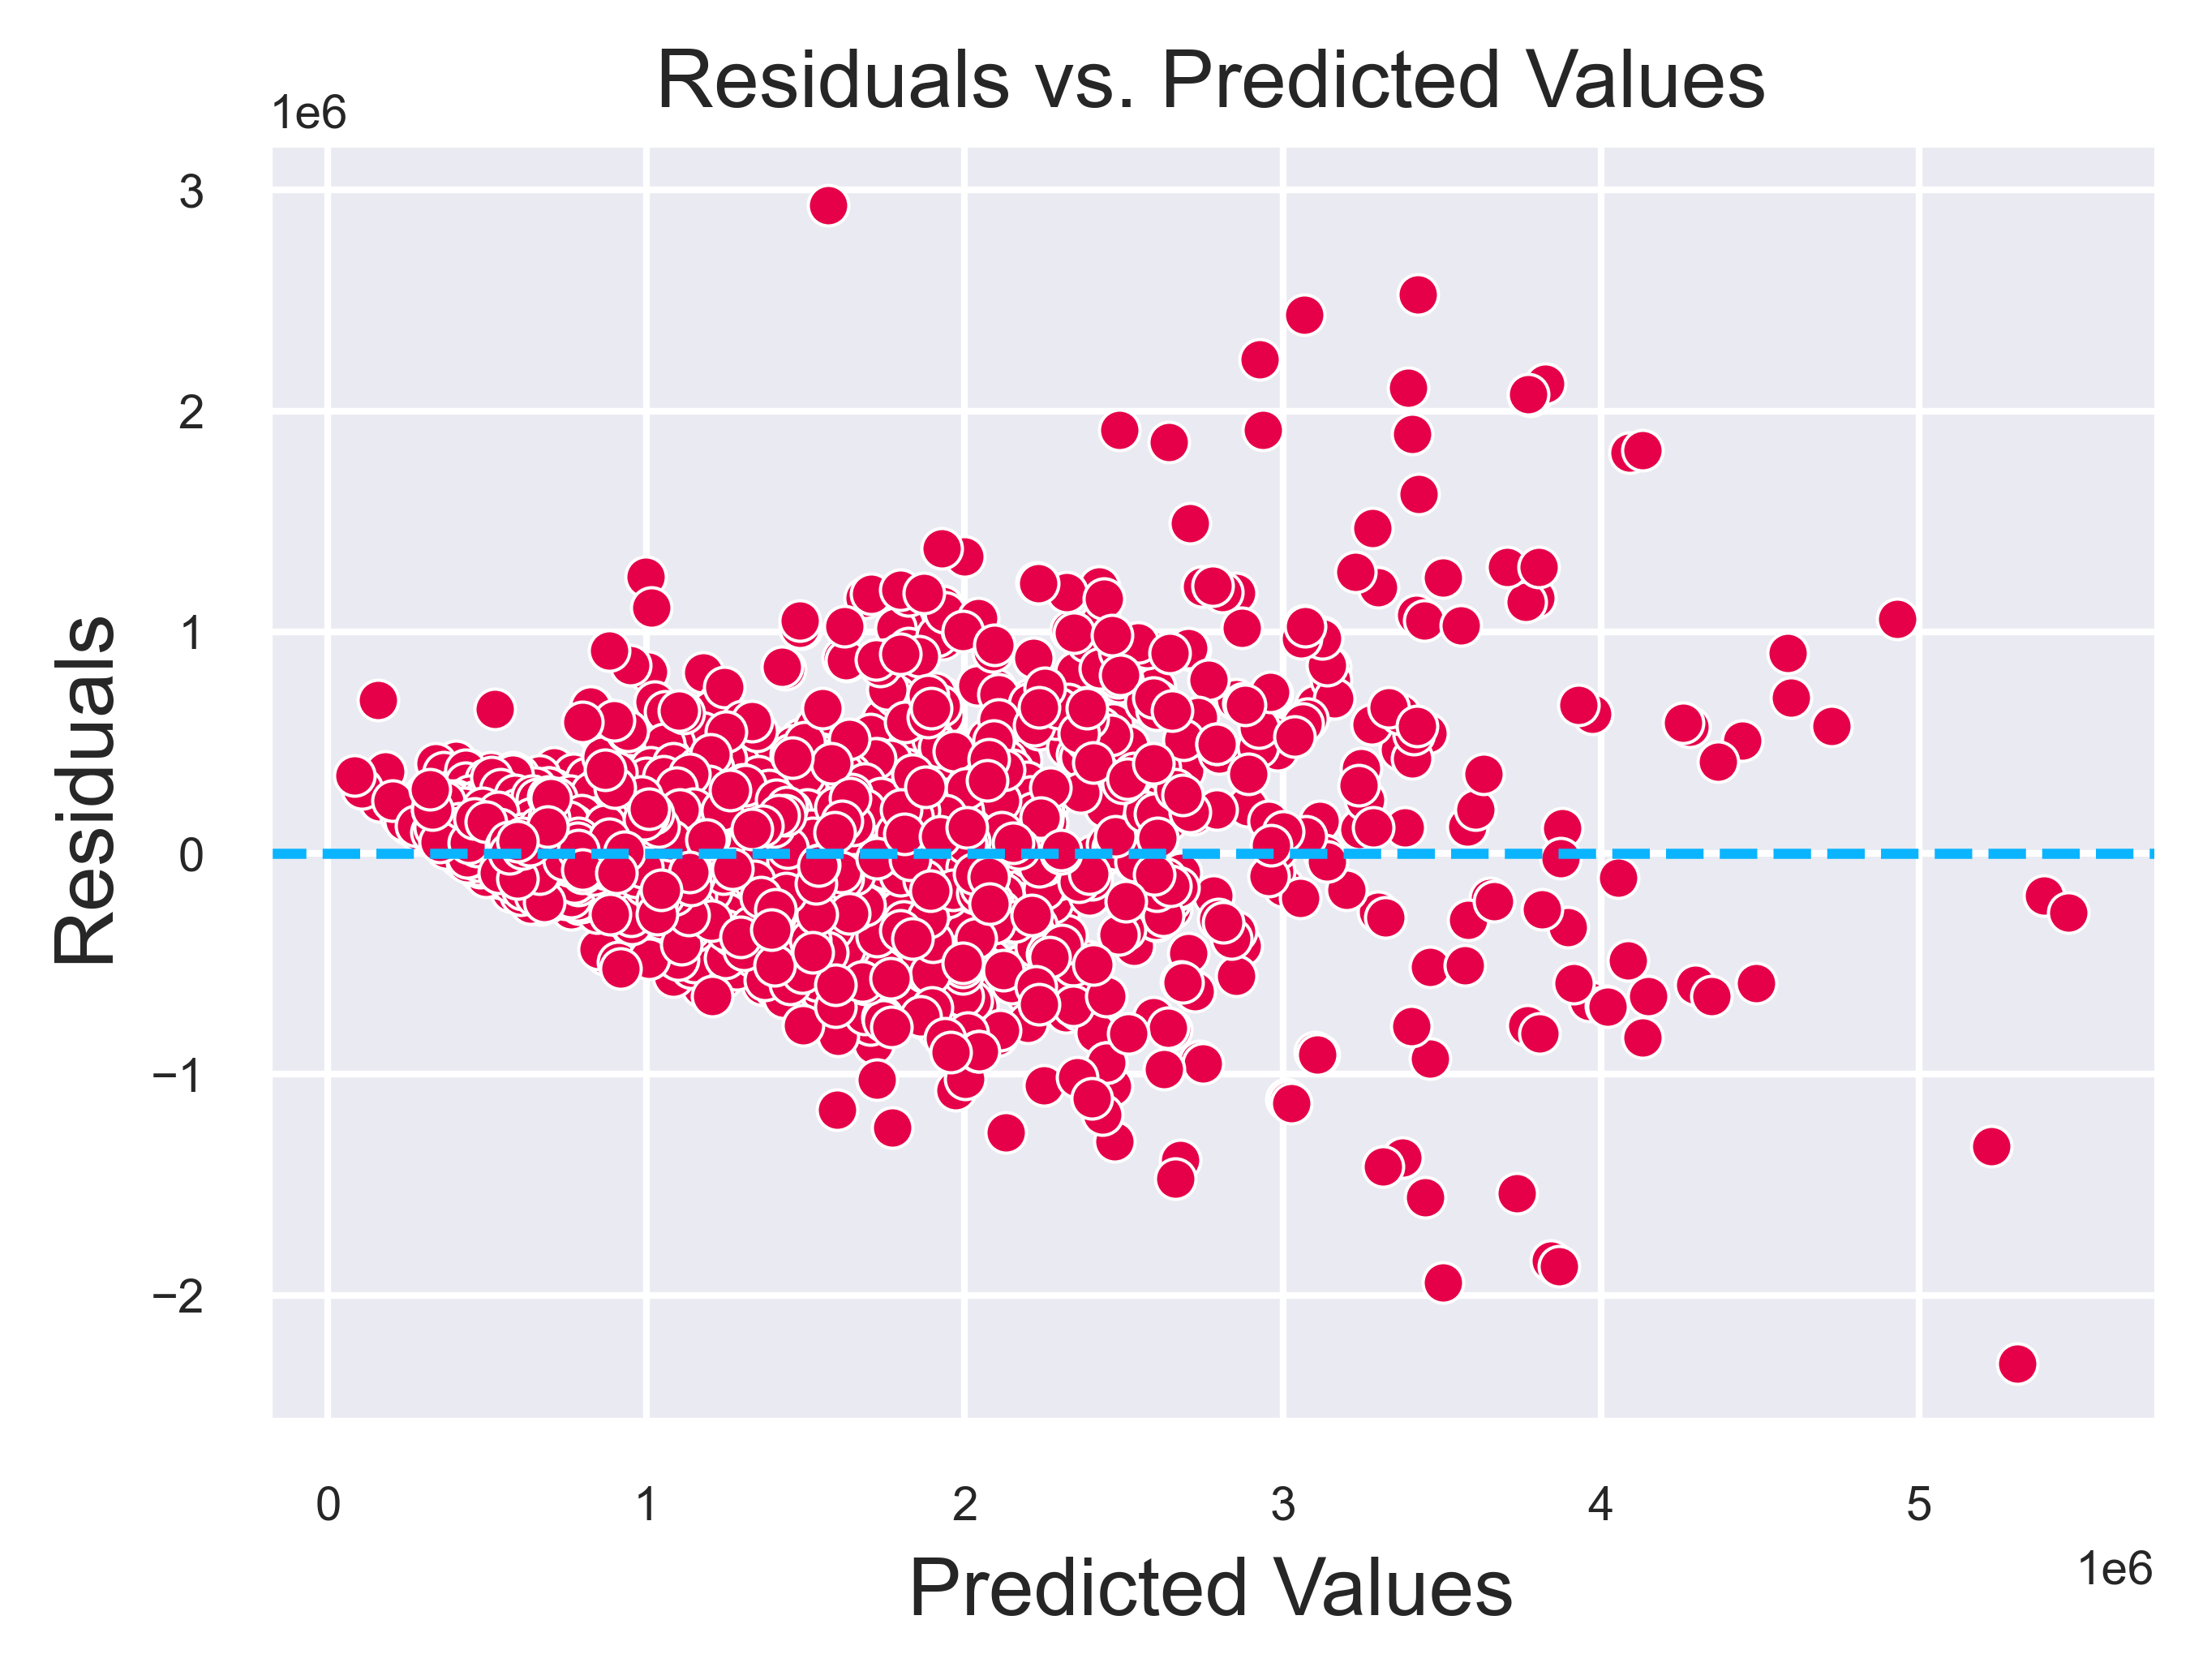

In [56]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [58]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(Lasso(tol=0.1), X_poly, Y, cv=kf, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

Cross-Validation R² Scores: [0.82268426 0.80554042 0.81751455 0.81341697 0.81810129]
Mean Cross-Validation R² Score: 0.8154514961381538
Standard Deviation of Cross-Validation R² Scores: 0.005761236718448741


#### ElasticNet with Grid Search

Training

In [12]:
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]}
grid_search = GridSearchCV(ElasticNet(tol=0.01, max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train, y_train)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)

/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.993e+14, tolerance: 9.497e+13
  model = cd_fast.enet_coordinate_descent(
/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.094e+14, tolerance: 9.570e+13
  model = cd_fast.enet_coordinate_descent(
/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did no

Evaluating with CV

In [13]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 175407.11463677013
MSE: 80828250968.84488
RMSE: 284303.09700888745
R²: 0.8366756107587292


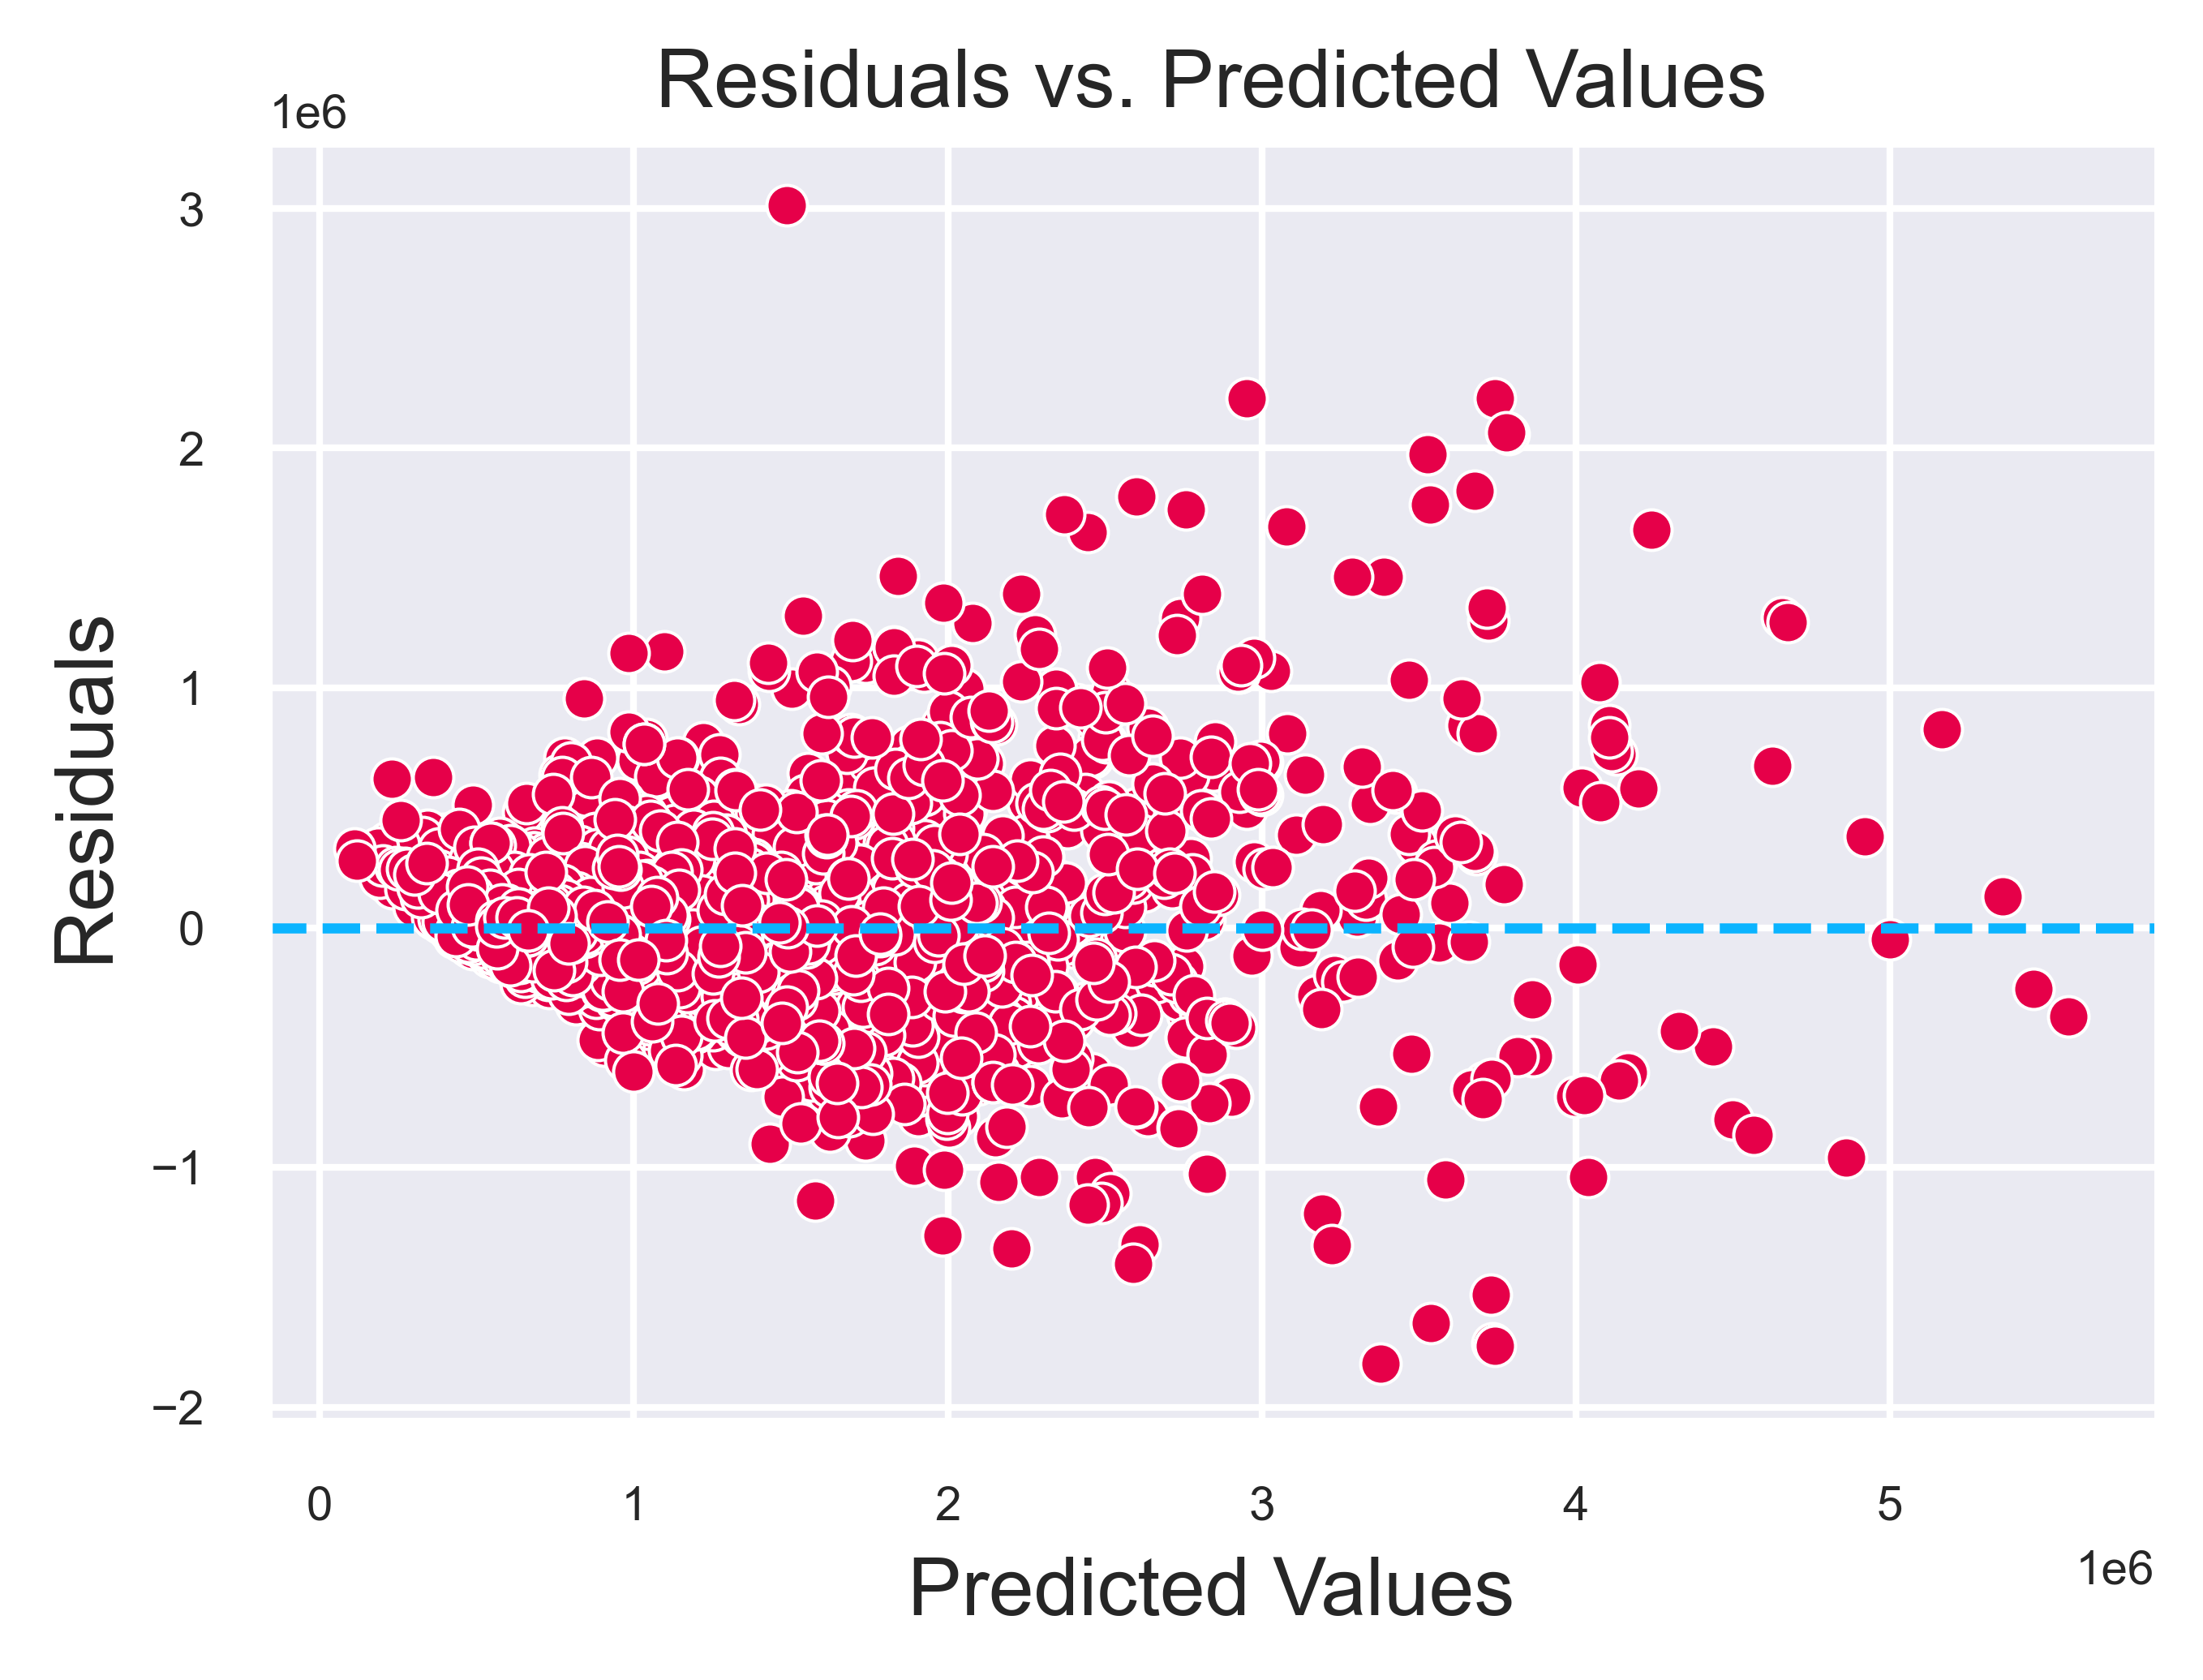

In [14]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42);

cv_scores = cross_val_score(model, X_poly, Y, cv=kf, scoring='r2');

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.400e+14, tolerance: 1.178e+14
  model = cd_fast.enet_coordinate_descent(
/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.326e+14, tolerance: 1.173e+14
  model = cd_fast.enet_coordinate_descent(
/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did no

Cross-Validation R² Scores: [0.83667561 0.82968585 0.83121408 0.82728036 0.84002296]
Mean Cross-Validation R² Score: 0.8329757740581771
Standard Deviation of Cross-Validation R² Scores: 0.004684366356589137


/Users/mateuszlambert/Desktop/SKN DS/apartment-price-prediction/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.137e+14, tolerance: 1.136e+14
  model = cd_fast.enet_coordinate_descent(


### 3rd degree Polynomial Regression

##### Creating new features and splitting the data

In [21]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=42)

##### Linear Regression

Training

In [22]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

Evaluation and CV

In [23]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 165946.26930491923
MSE: 158481574608.6581
RMSE: 398097.4436098003
R²: 0.6797665906573818


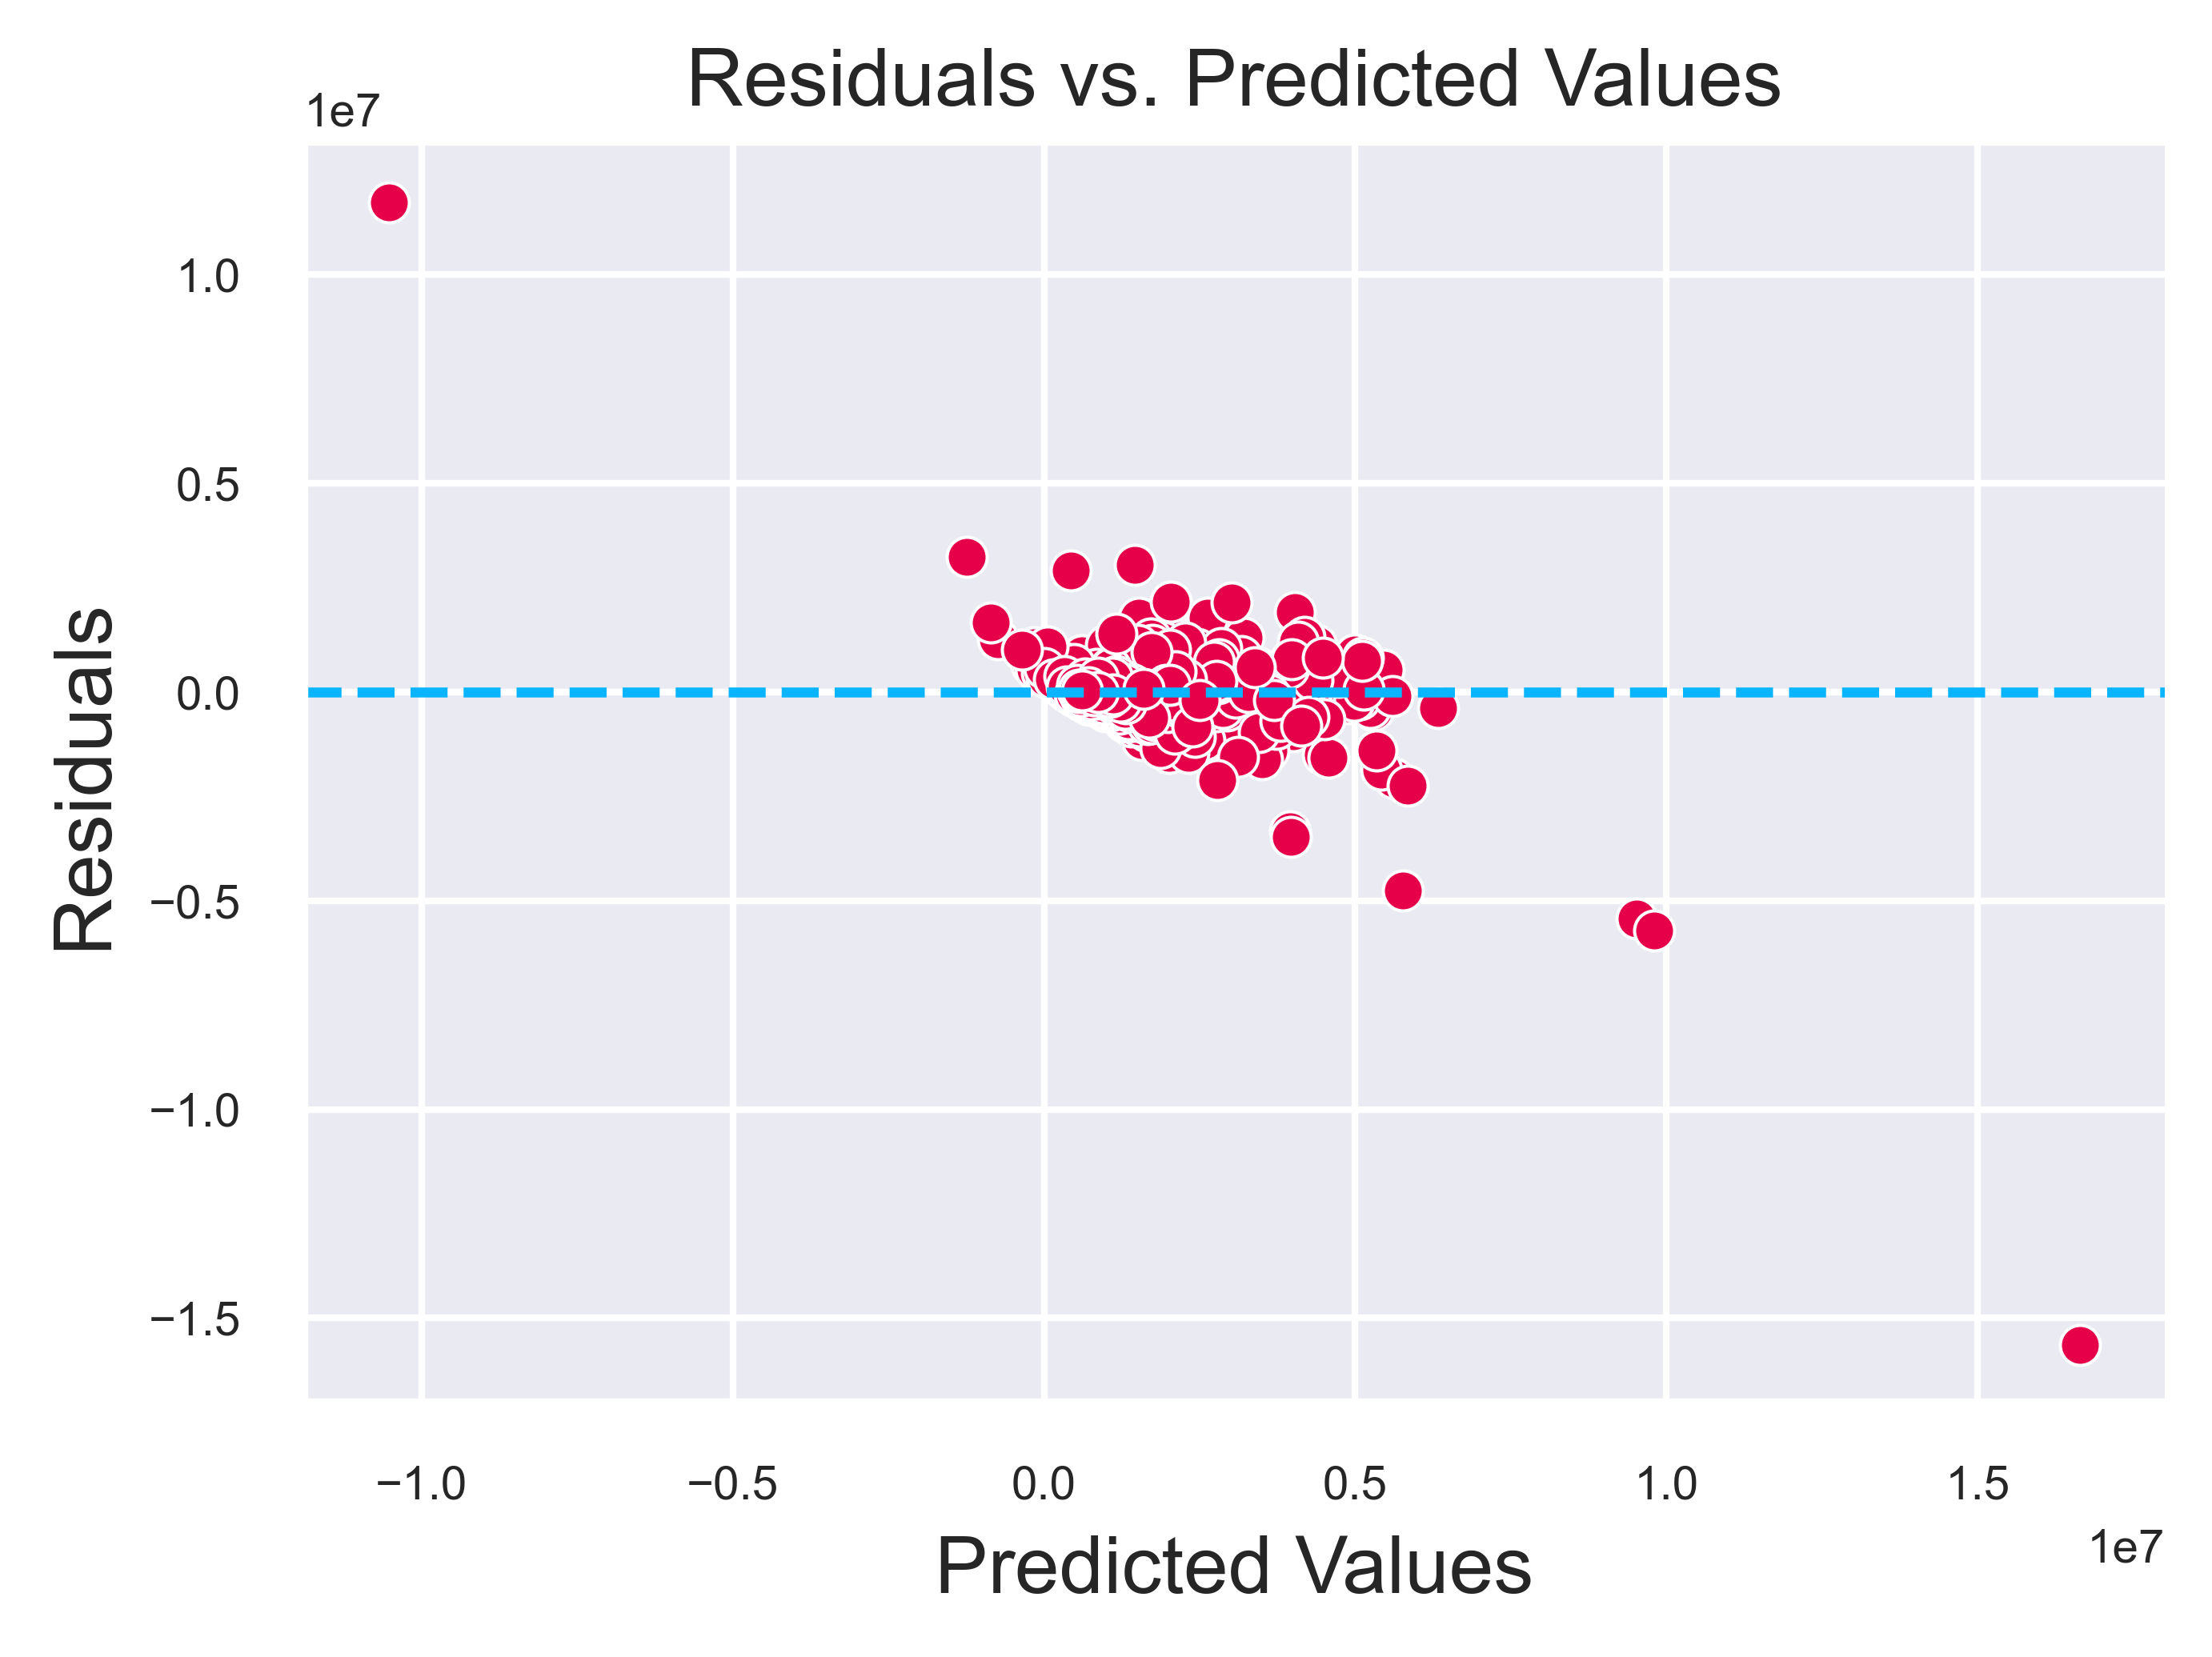

In [24]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [25]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

cv_scores = cross_val_score(LinearRegression(), X_poly, Y, cv=kf, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

Cross-Validation R² Scores: [-6.37377238e+05 -1.88335897e+00 -4.83194786e-01]
Mean Cross-Validation R² Score: -212459.86811385793
Standard Deviation of Cross-Validation R² Scores: 300461.9535409491


### Gradient Boosting

##### Training

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

n_estimators_range = [500, 1000, 2000]
cv_scores = []

for n in n_estimators_range:
    model = GradientBoostingRegressor(n_estimators=n, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_scores.append(np.mean(scores))

best_n_estimators = n_estimators_range[np.argmax(cv_scores)]
print(f"Best n_estimators: {best_n_estimators}")

Best n_estimators: 2500


In [143]:
model = GradientBoostingRegressor(n_estimators=best_n_estimators, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

##### Evaluation and CV

In [144]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 102553.21651251873
MSE: 27266801051.13586
RMSE: 165126.62126724407
R²: 0.9449037486910791


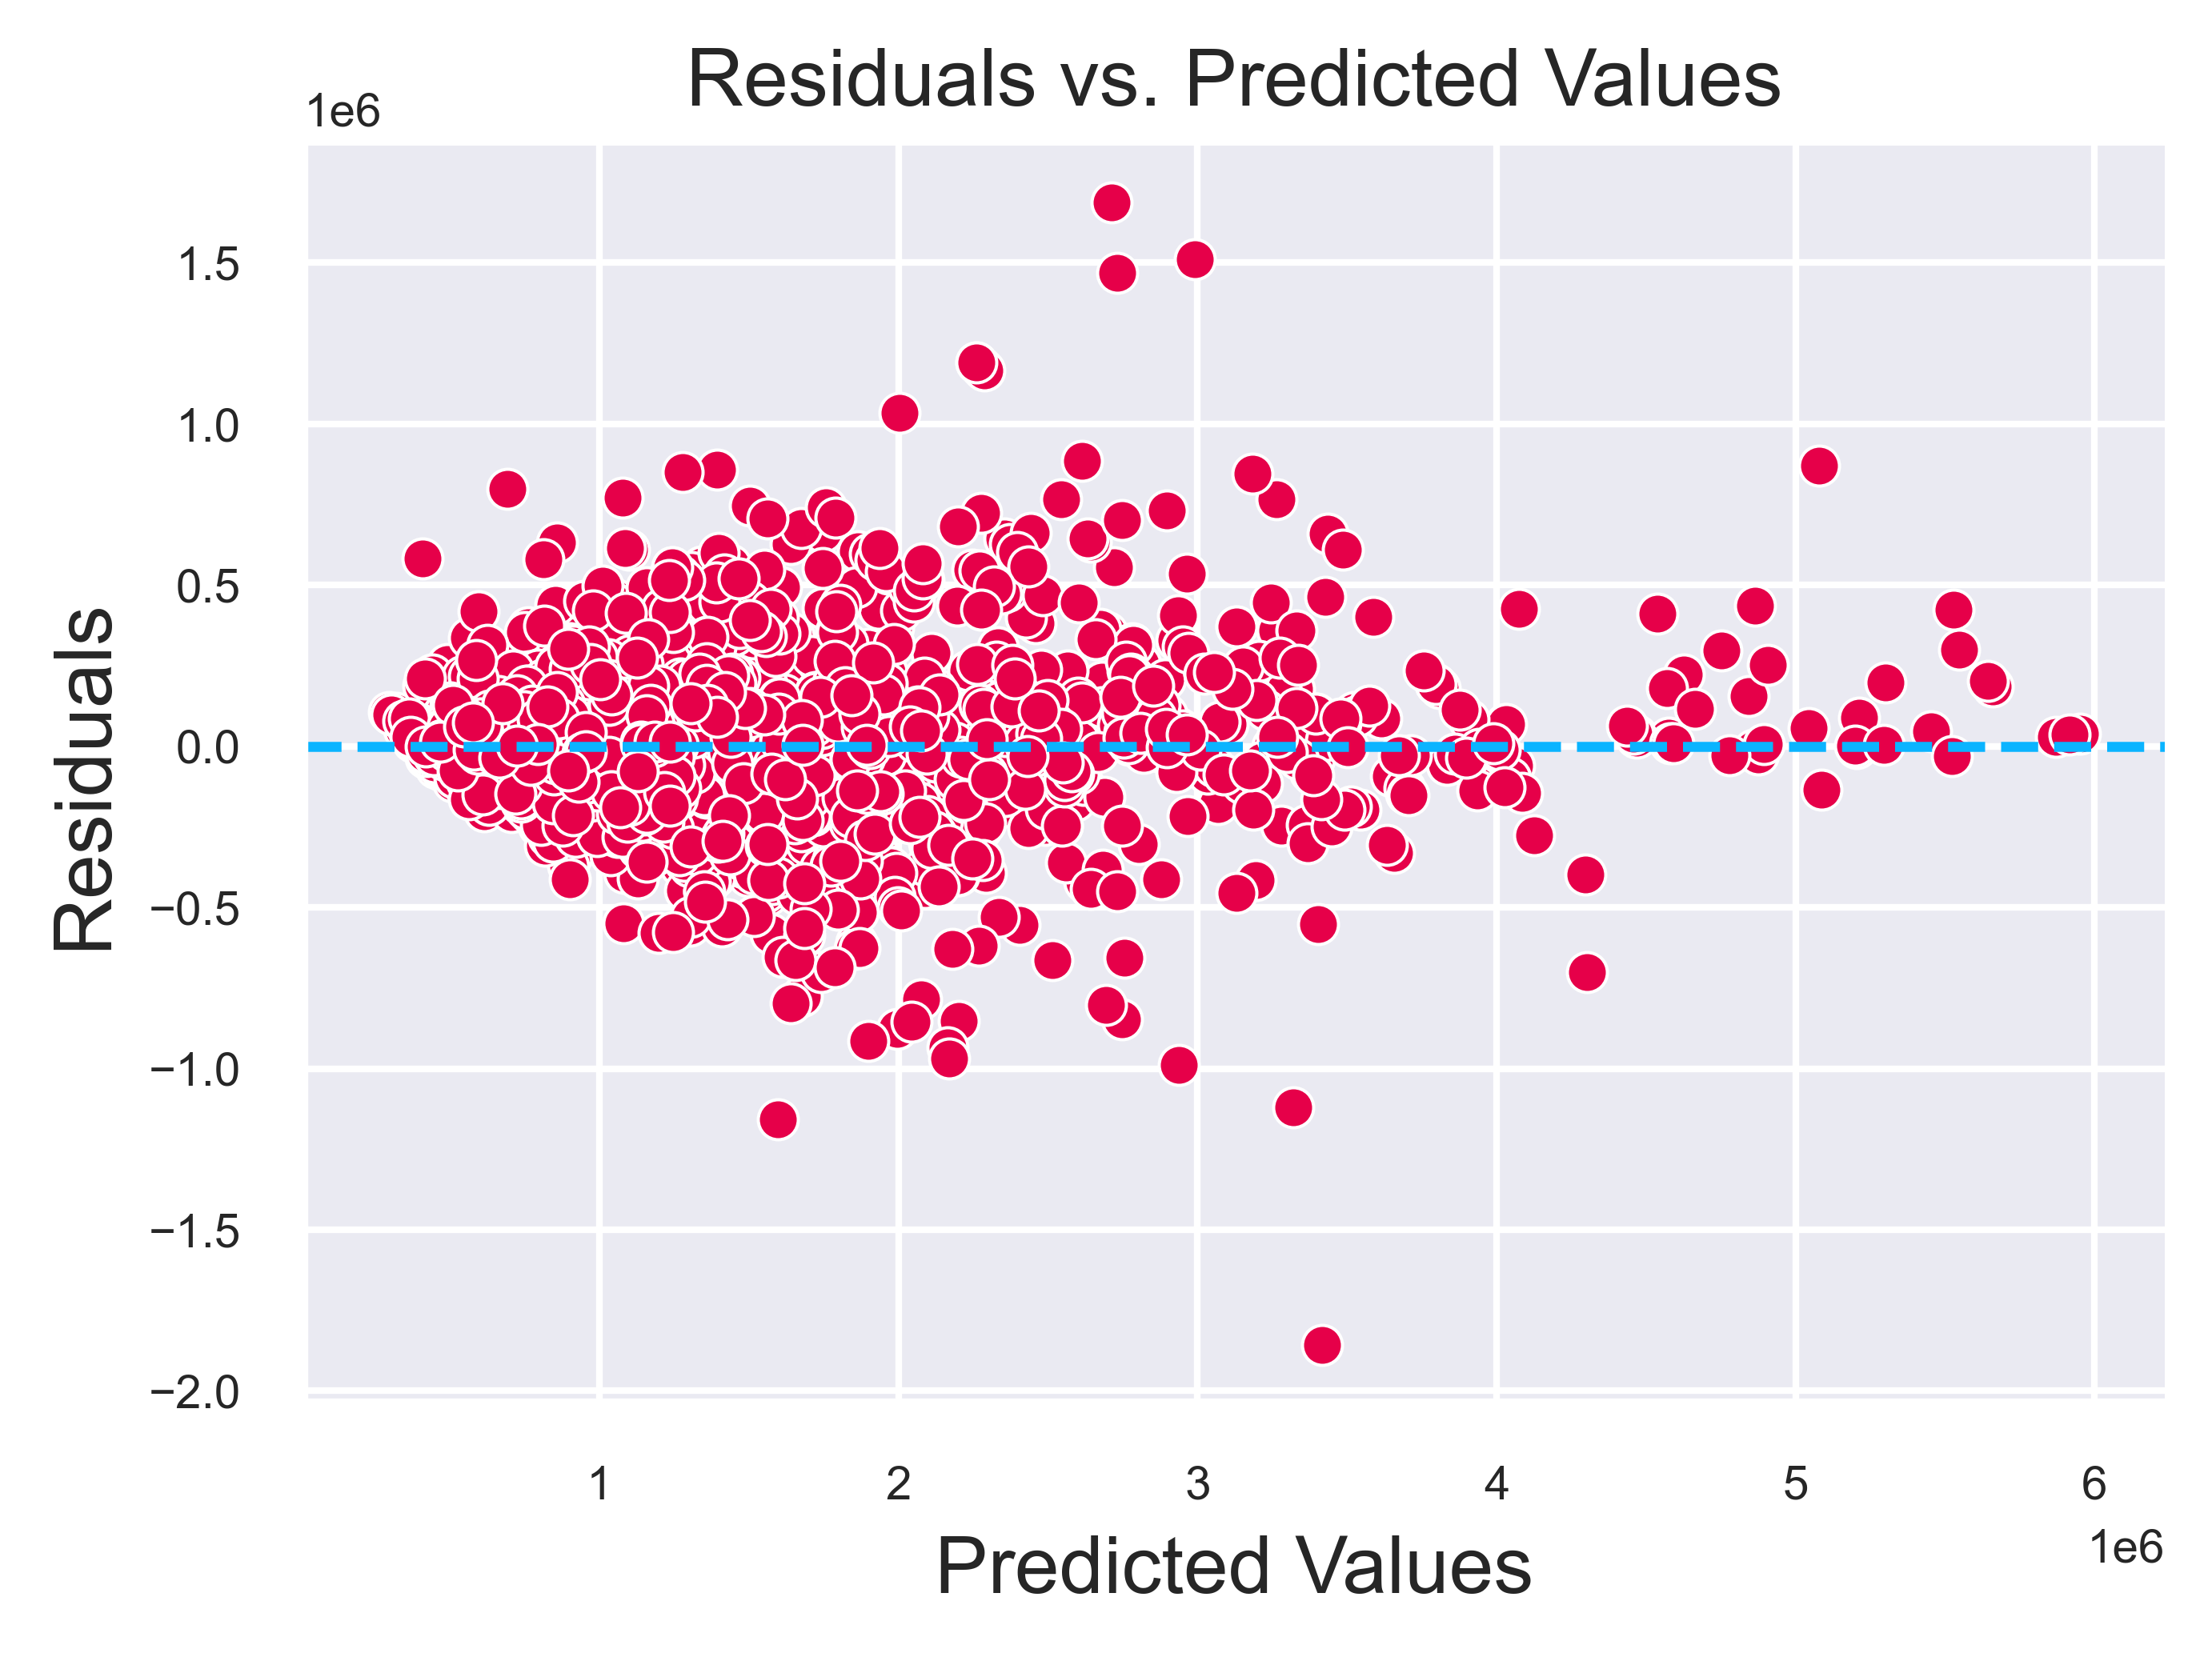

In [145]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

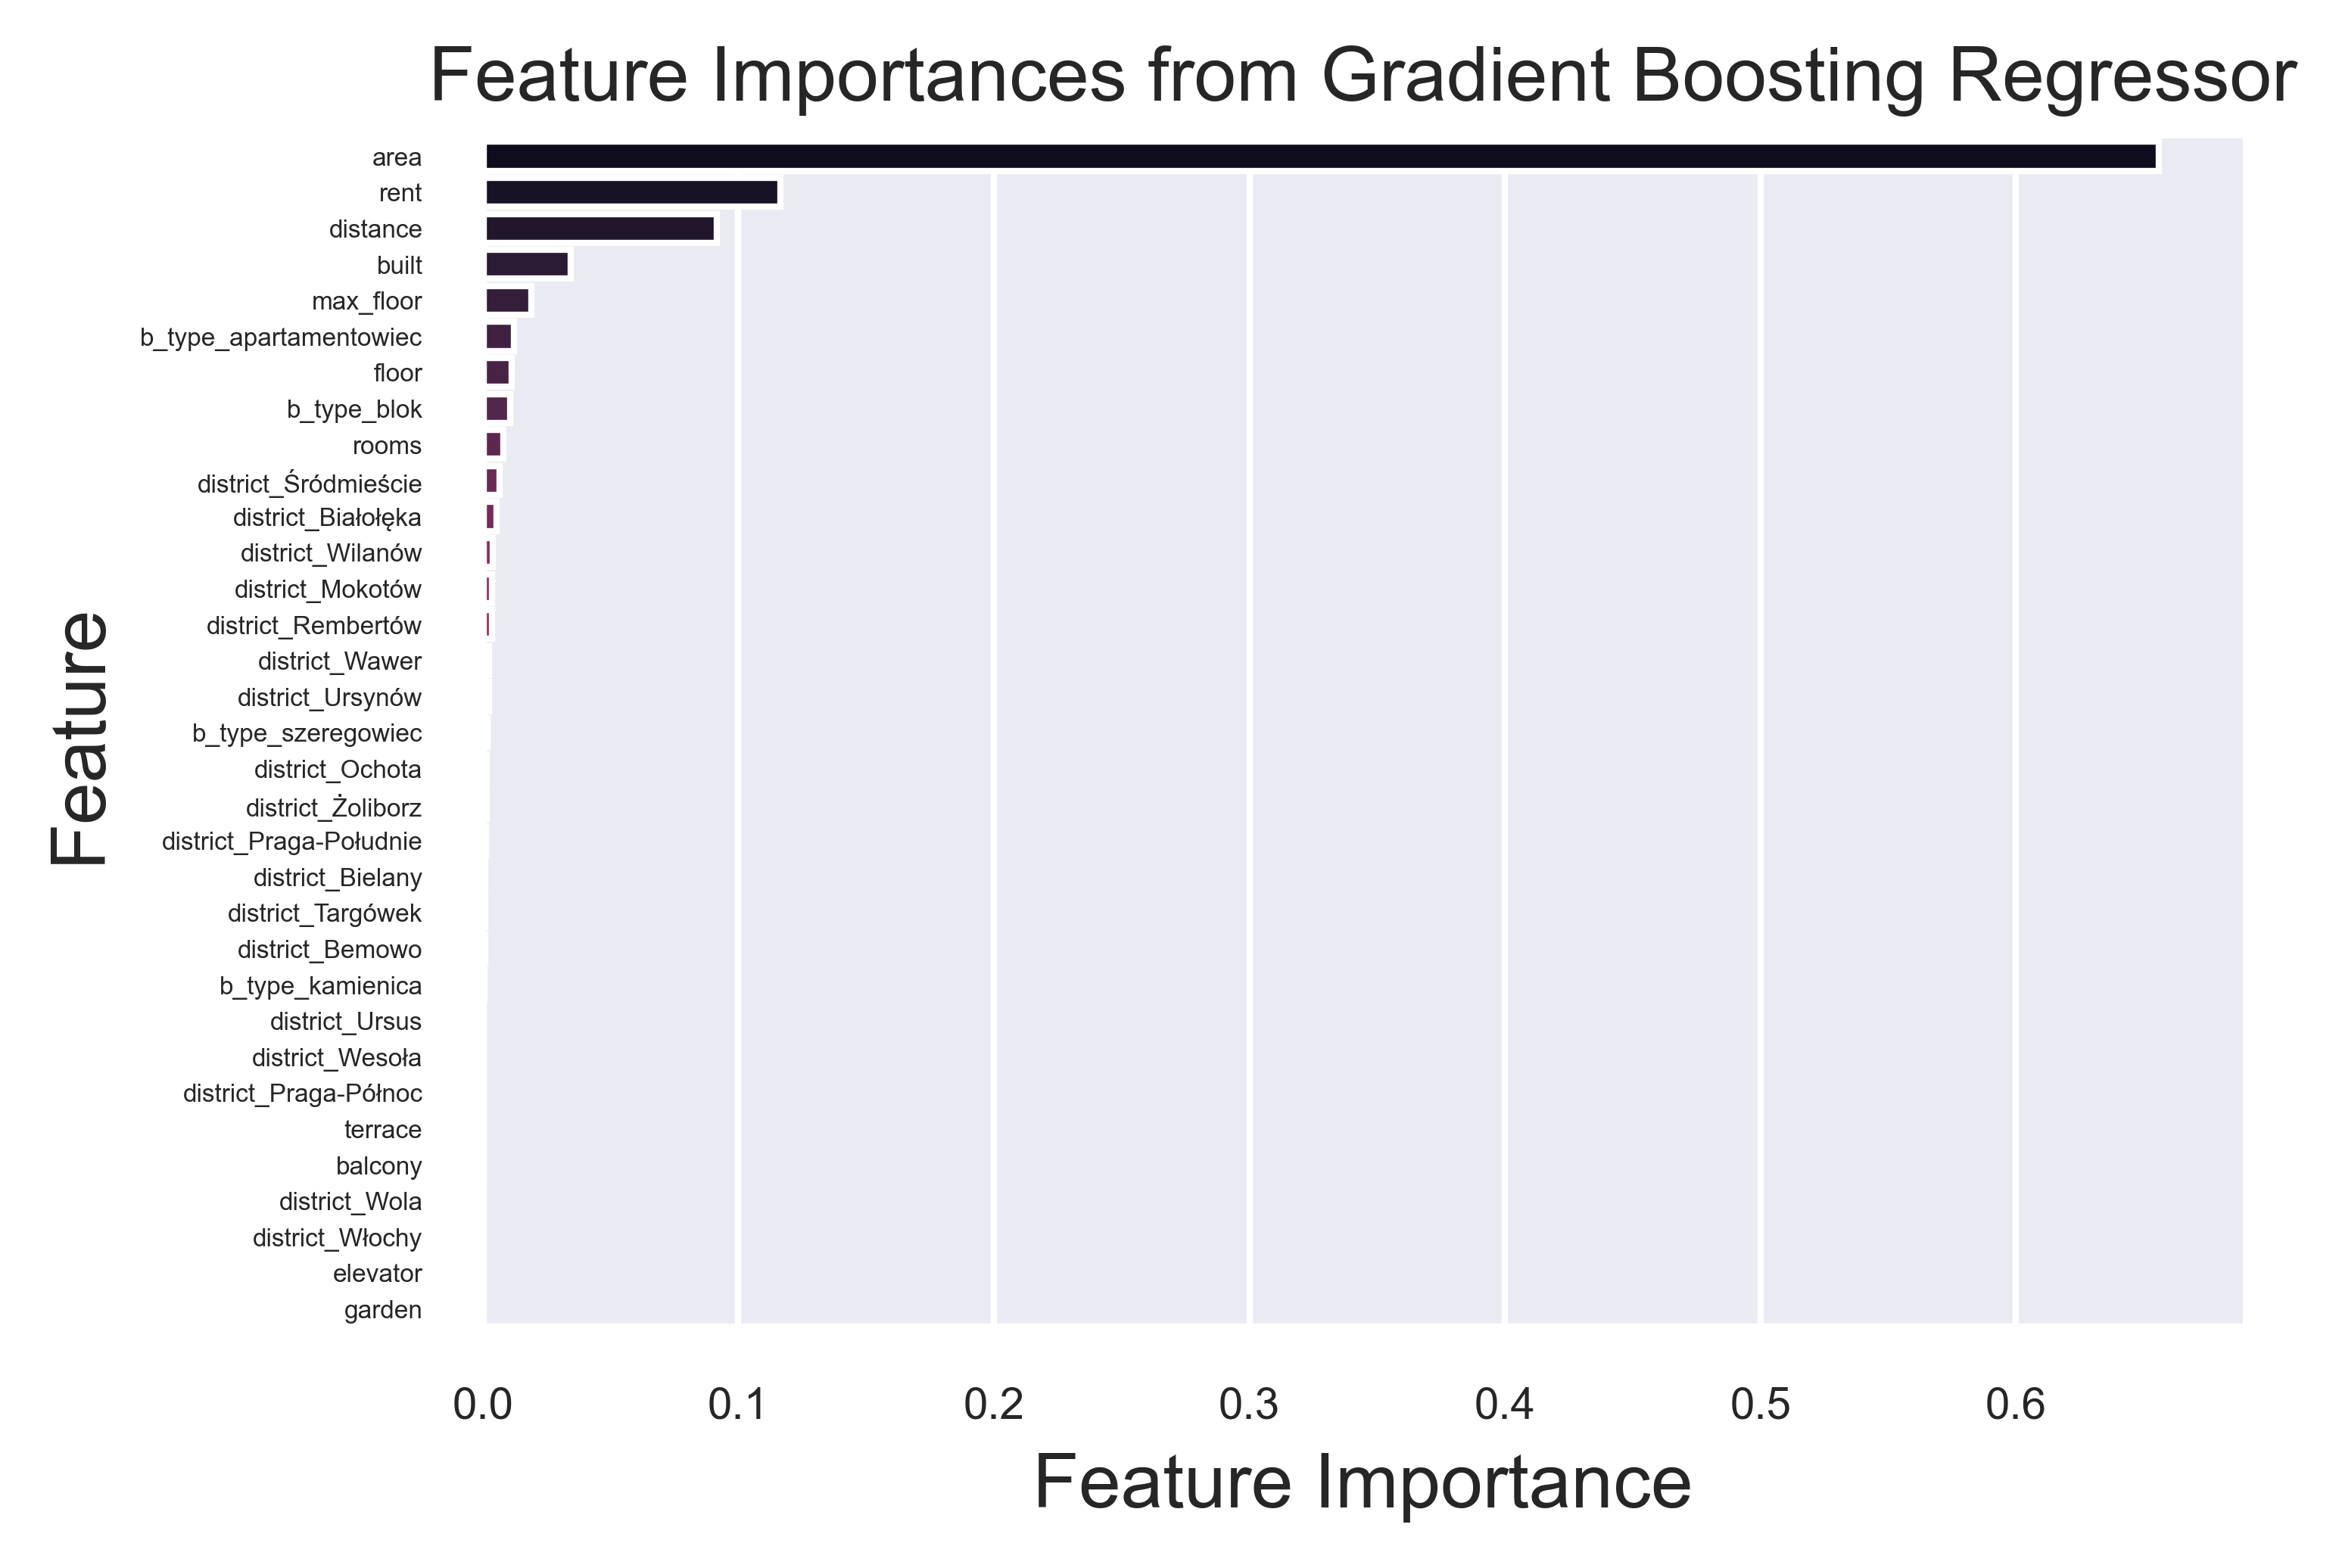

In [58]:
feature_importances = model.feature_importances_
feature_names = X.columns

features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=features_df, hue='Feature', palette='rocket')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.yticks(fontsize=4)
plt.title('Feature Importances from Gradient Boosting Regressor');

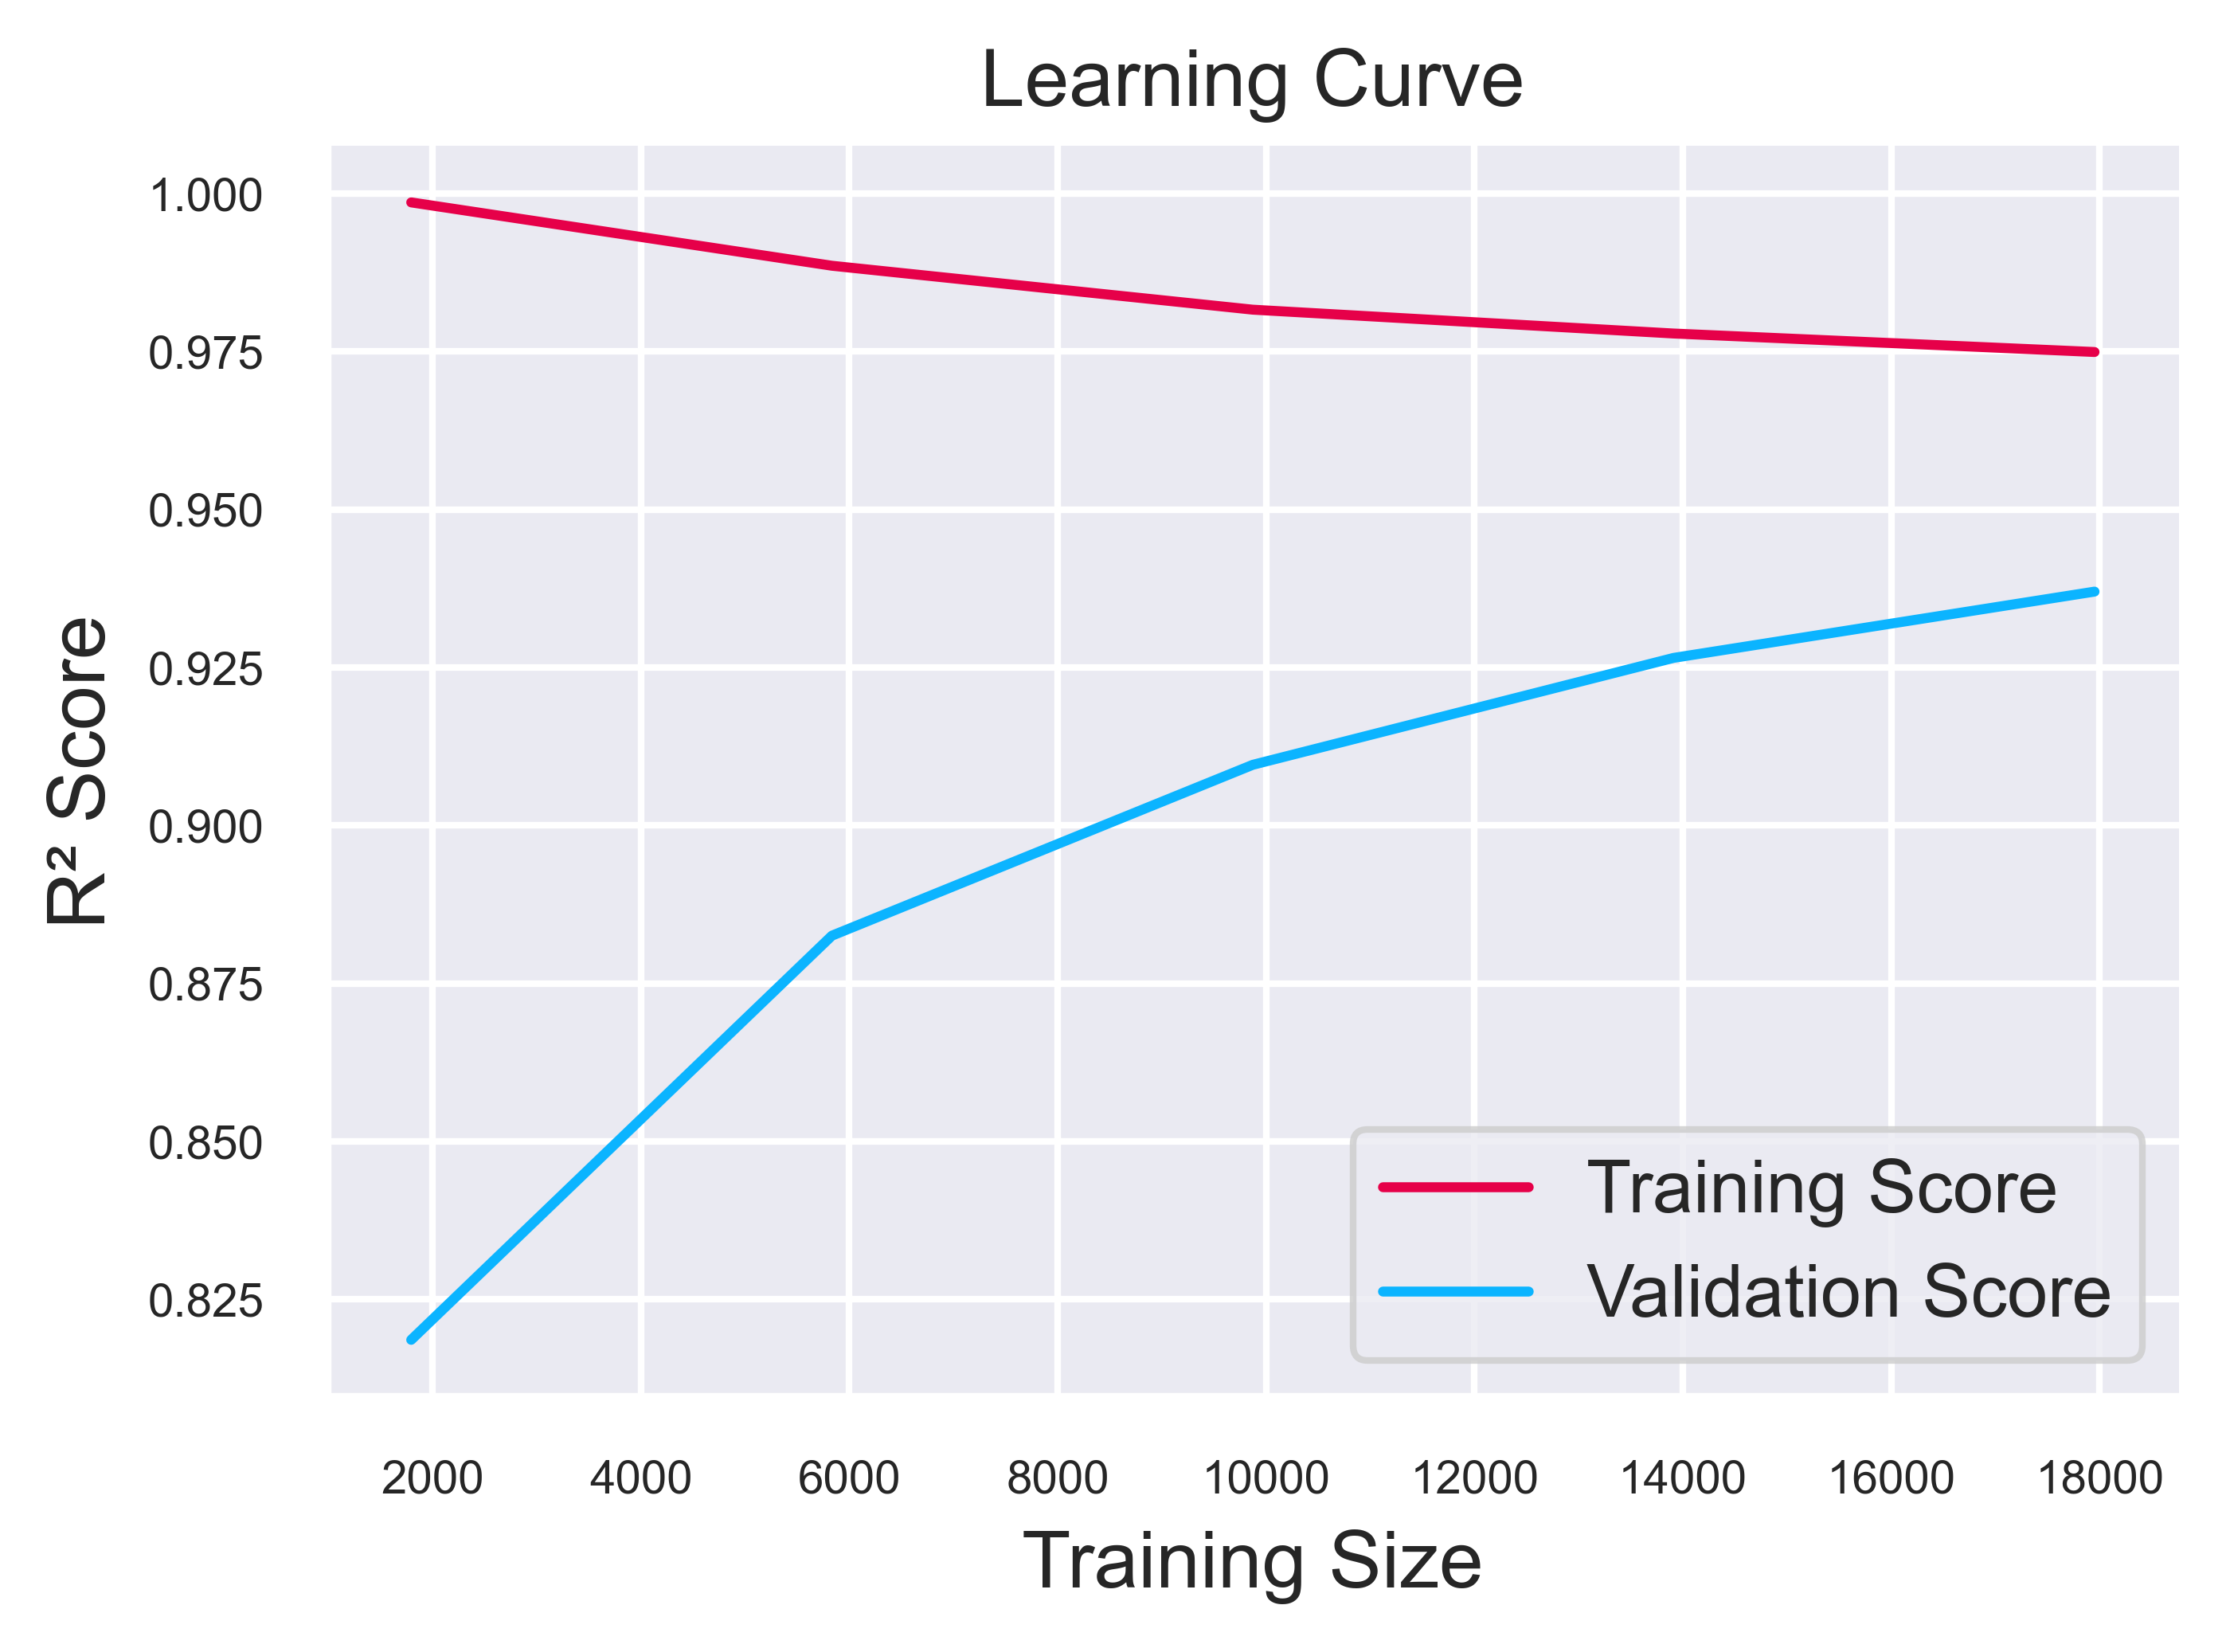

In [147]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend();

### Regression Tree

##### Training

In [138]:
model = DecisionTreeRegressor(max_depth=11)
model.fit(X_train, y_train);
y_pred = model.predict(X_test)

##### Evaluation

In [139]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 131860.45257144907
MSE: 57409871509.87943
RMSE: 239603.57157162626
R²: 0.8839956068777856


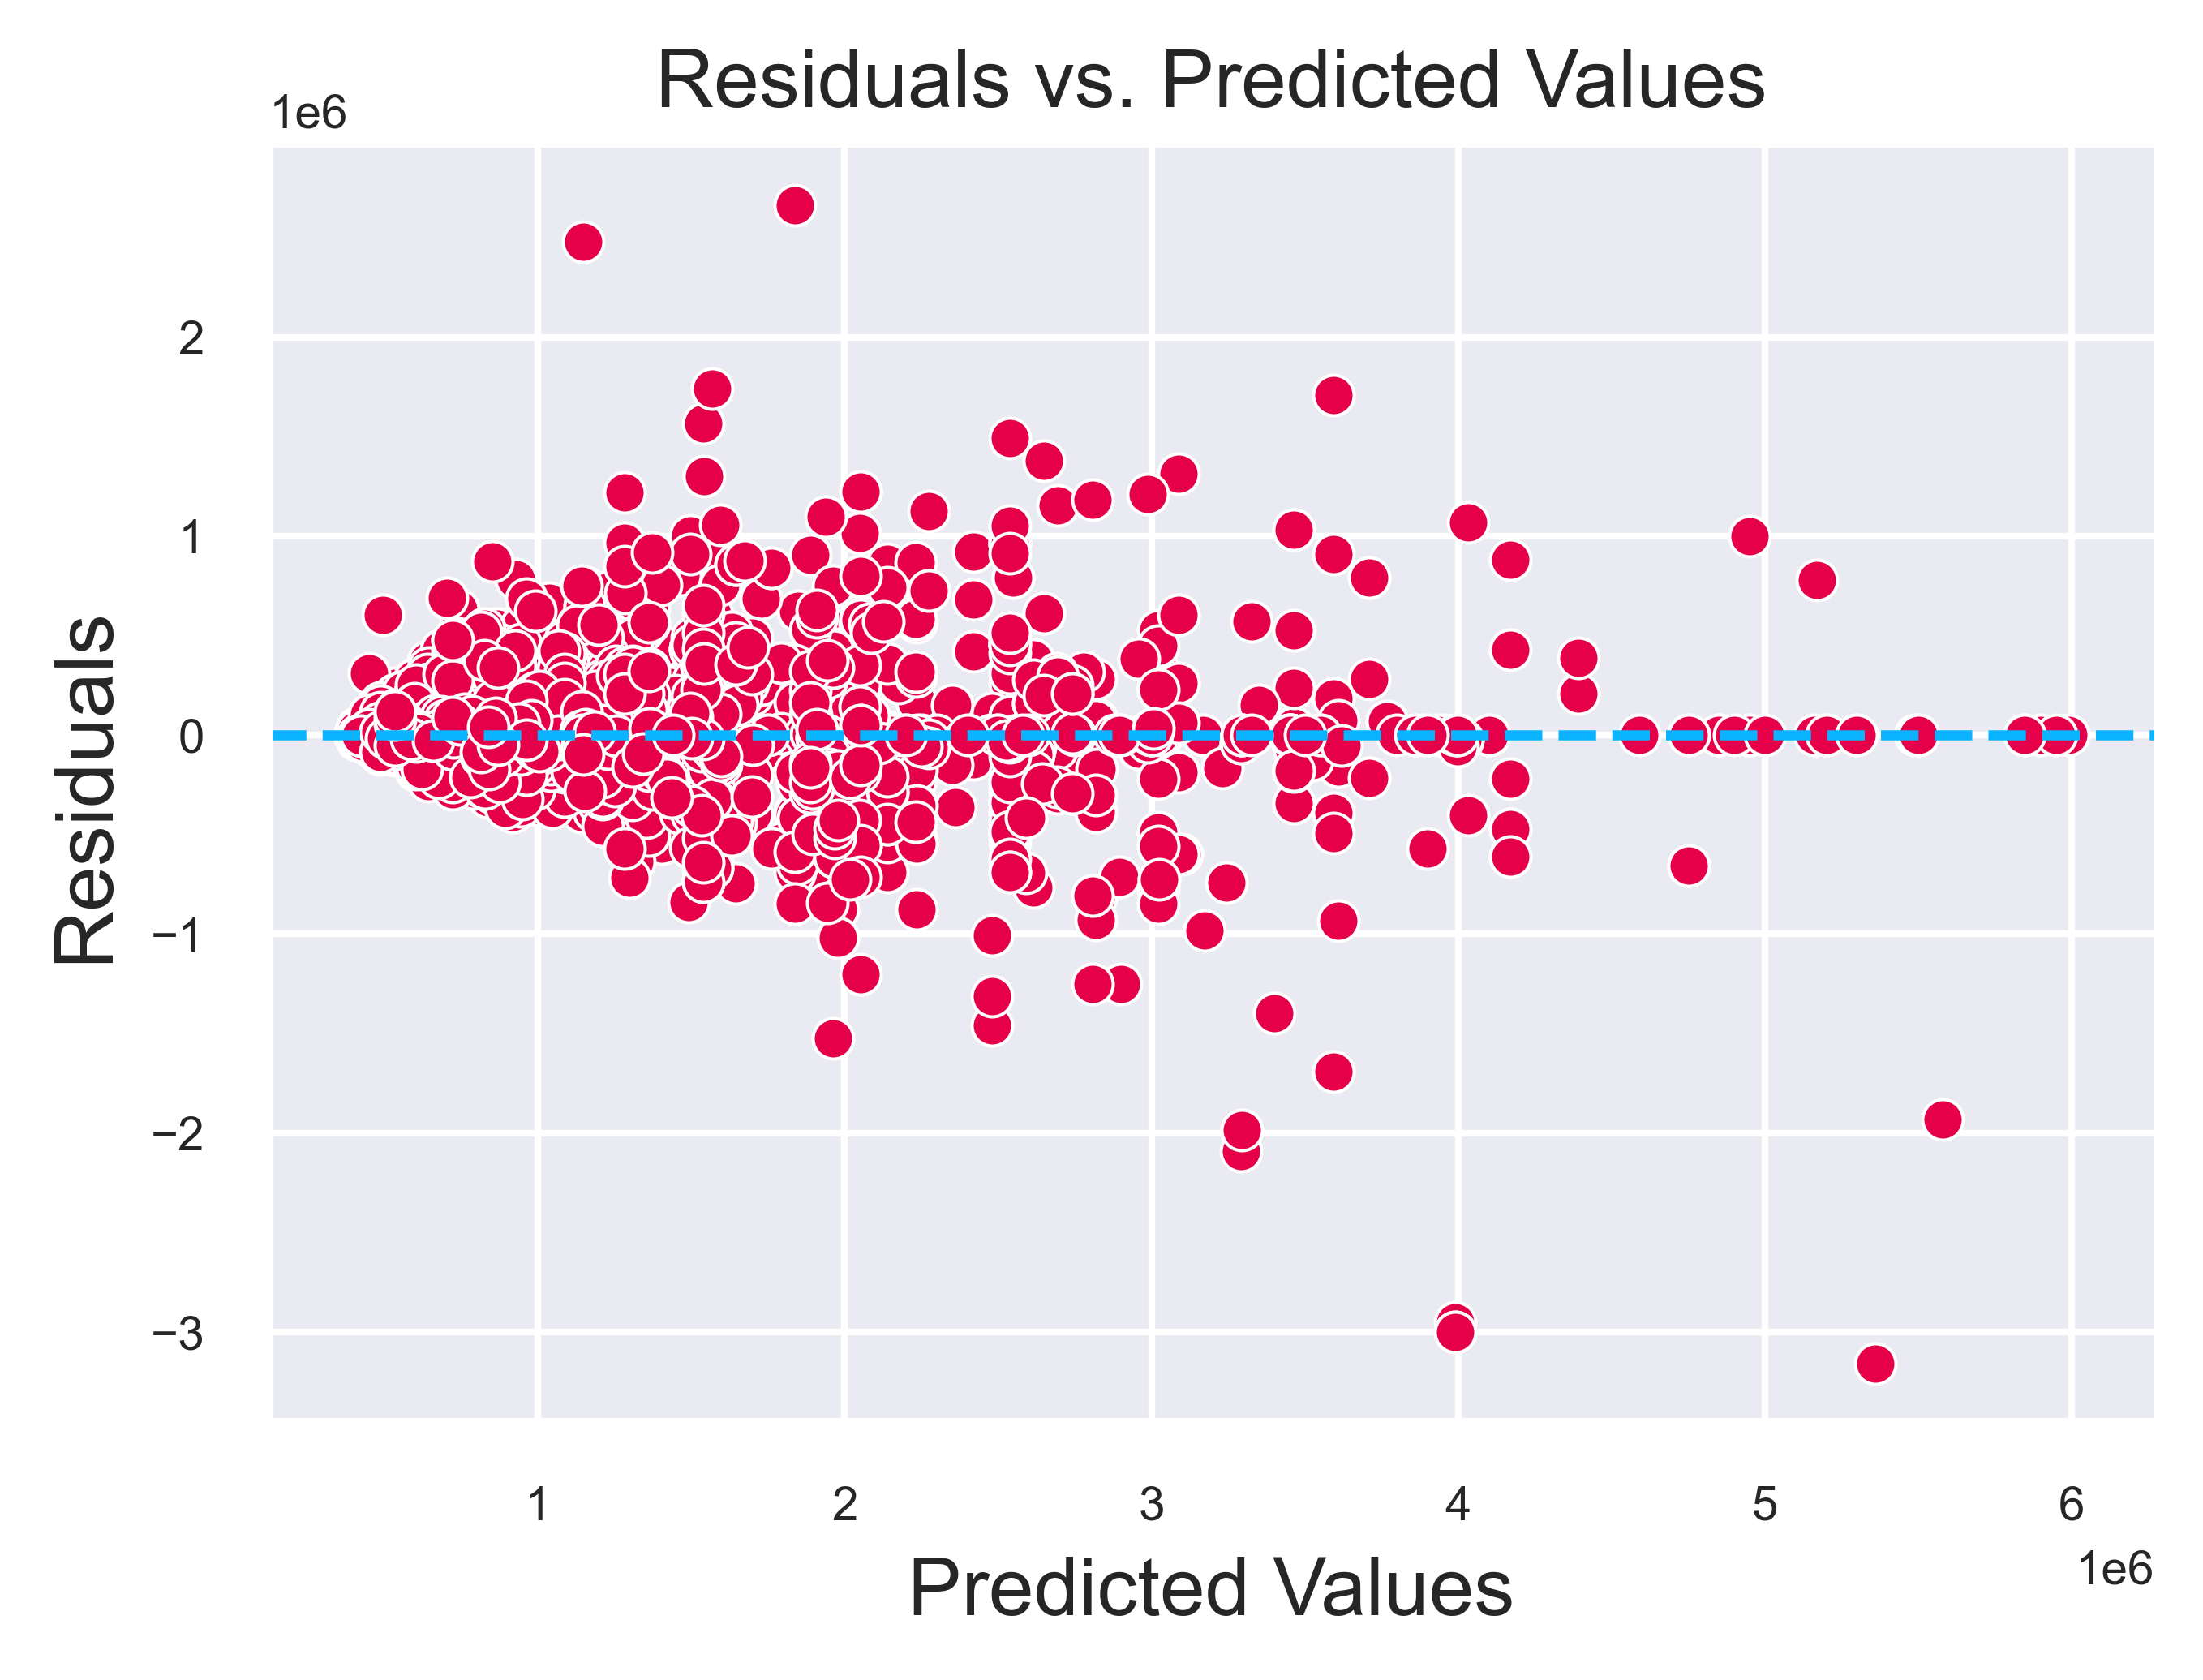

In [140]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [141]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

Cross-Validation R² Scores: [0.87640104 0.89318403 0.90553962 0.87712166 0.88835275 0.86306226
 0.88470867 0.88364986 0.86912667 0.88245446]
Mean Cross-Validation R² Score: 0.8823601013169252
Standard Deviation of Cross-Validation R² Scores: 0.01143691142382093


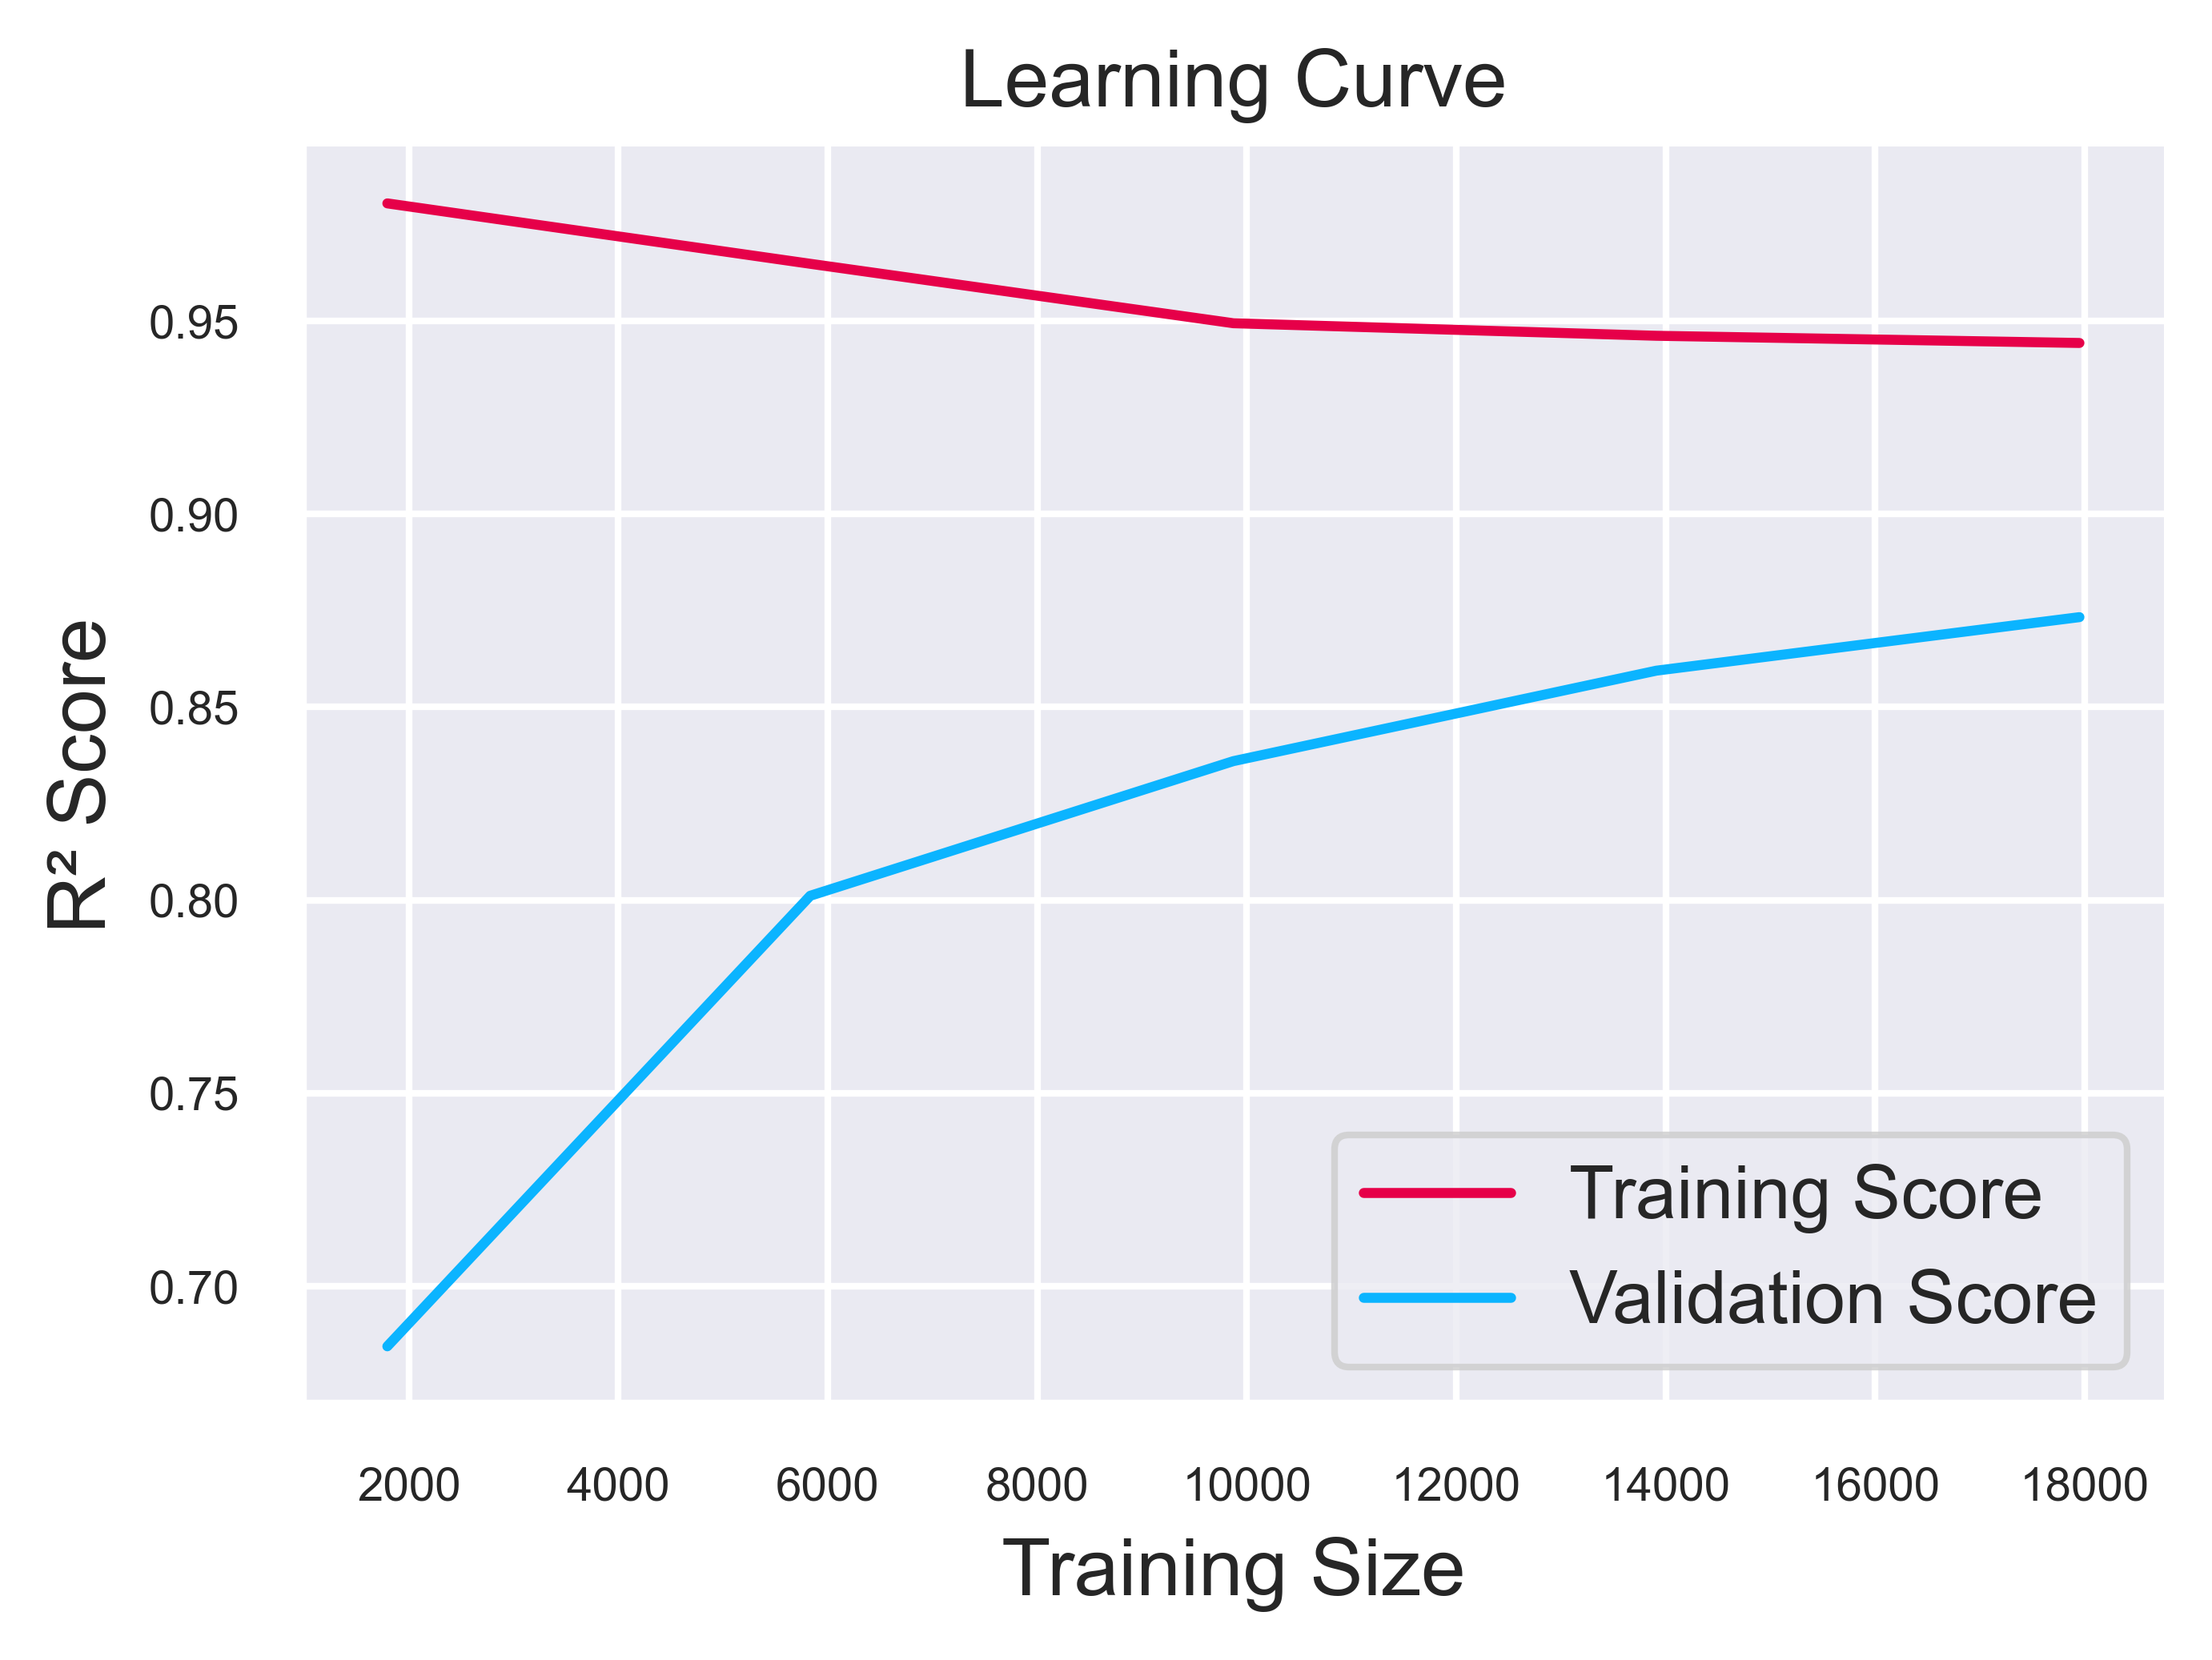

In [142]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend();

### Random Forest

##### Training

In [203]:
model = RandomForestRegressor(n_estimators=100, max_depth=12, min_samples_split=5, max_leaf_nodes=200)
model.fit(X_train, y_train);
y_pred = model.predict(X_test)

##### Evaluation

In [204]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 147764.39703994655
MSE: 51266128644.97395
RMSE: 226420.2478688113
R²: 0.8964098684637856


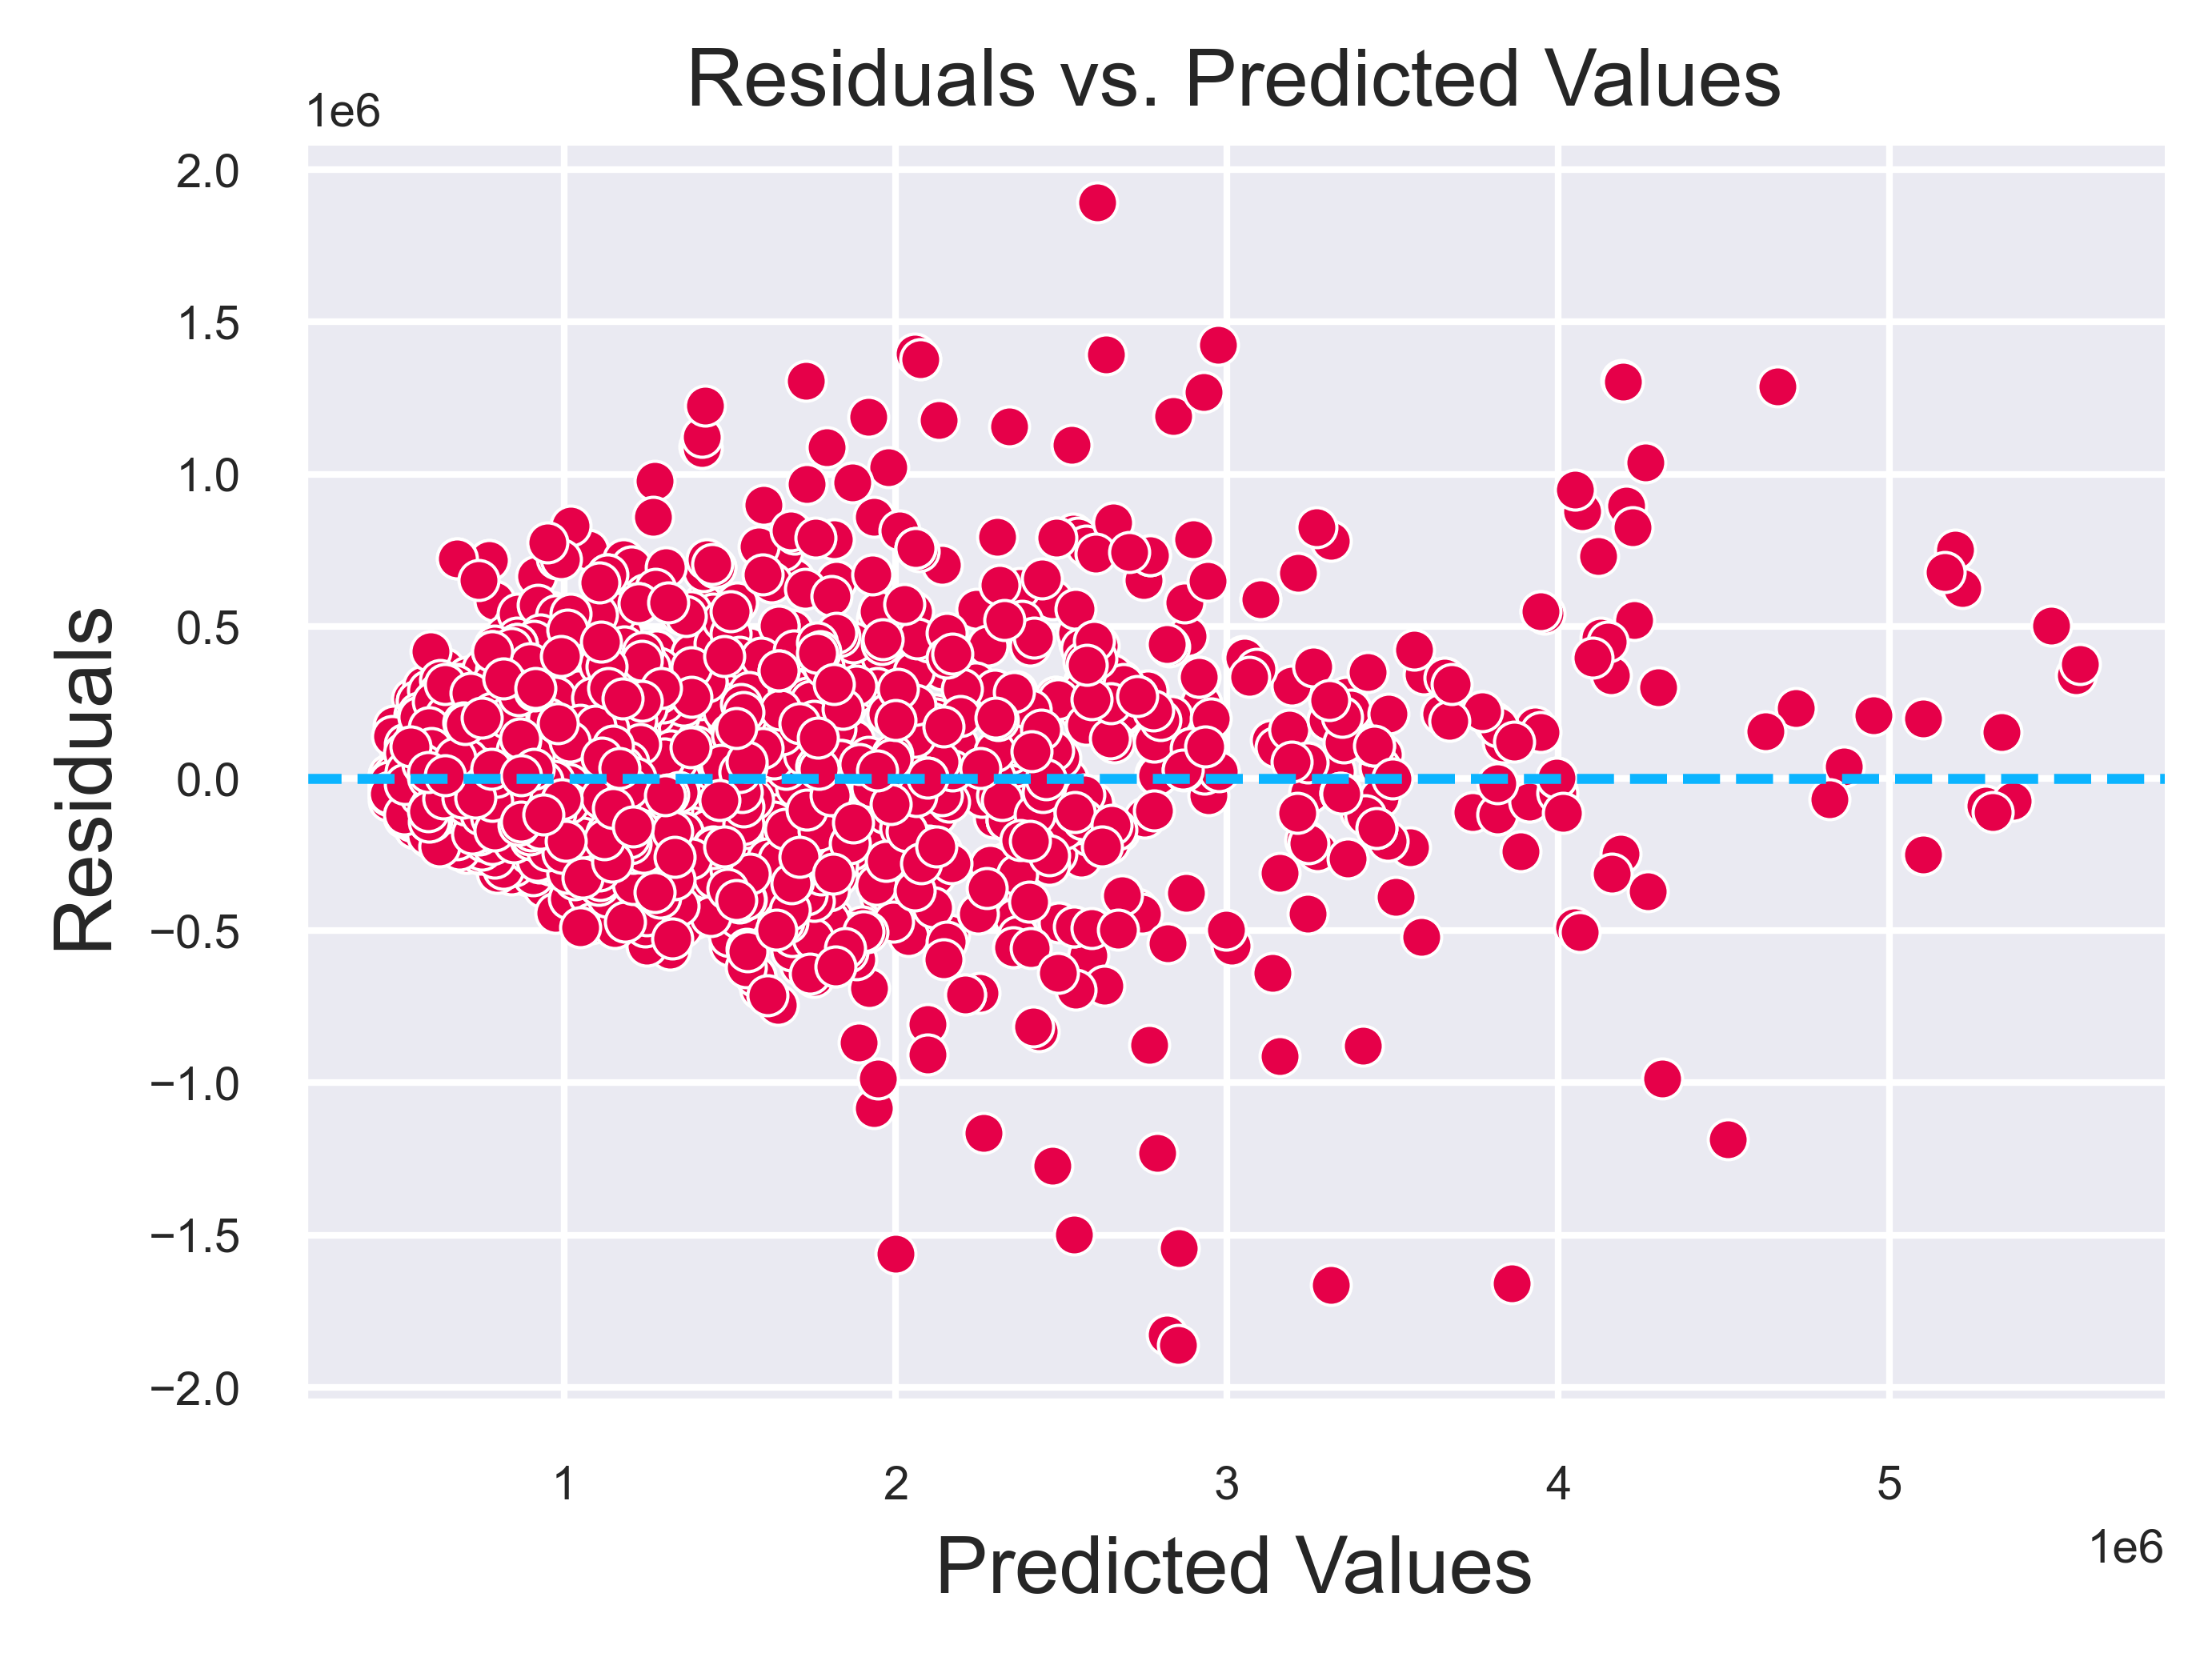

In [206]:
residuals = y_test - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="#0bb4ff", linestyle='--')
plt.xlabel('Predicted Values');
plt.ylabel('Residuals');
plt.title('Residuals vs. Predicted Values');

In [207]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

print(f"Cross-Validation R² Scores: {cv_scores}")
print(f"Mean Cross-Validation R² Score: {np.mean(cv_scores)}")
print(f"Standard Deviation of Cross-Validation R² Scores: {np.std(cv_scores)}")

Cross-Validation R² Scores: [0.90197408 0.90192981 0.8992195  0.89810841 0.89879988]
Mean Cross-Validation R² Score: 0.9000063359991074
Standard Deviation of Cross-Validation R² Scores: 0.0016277926226380452


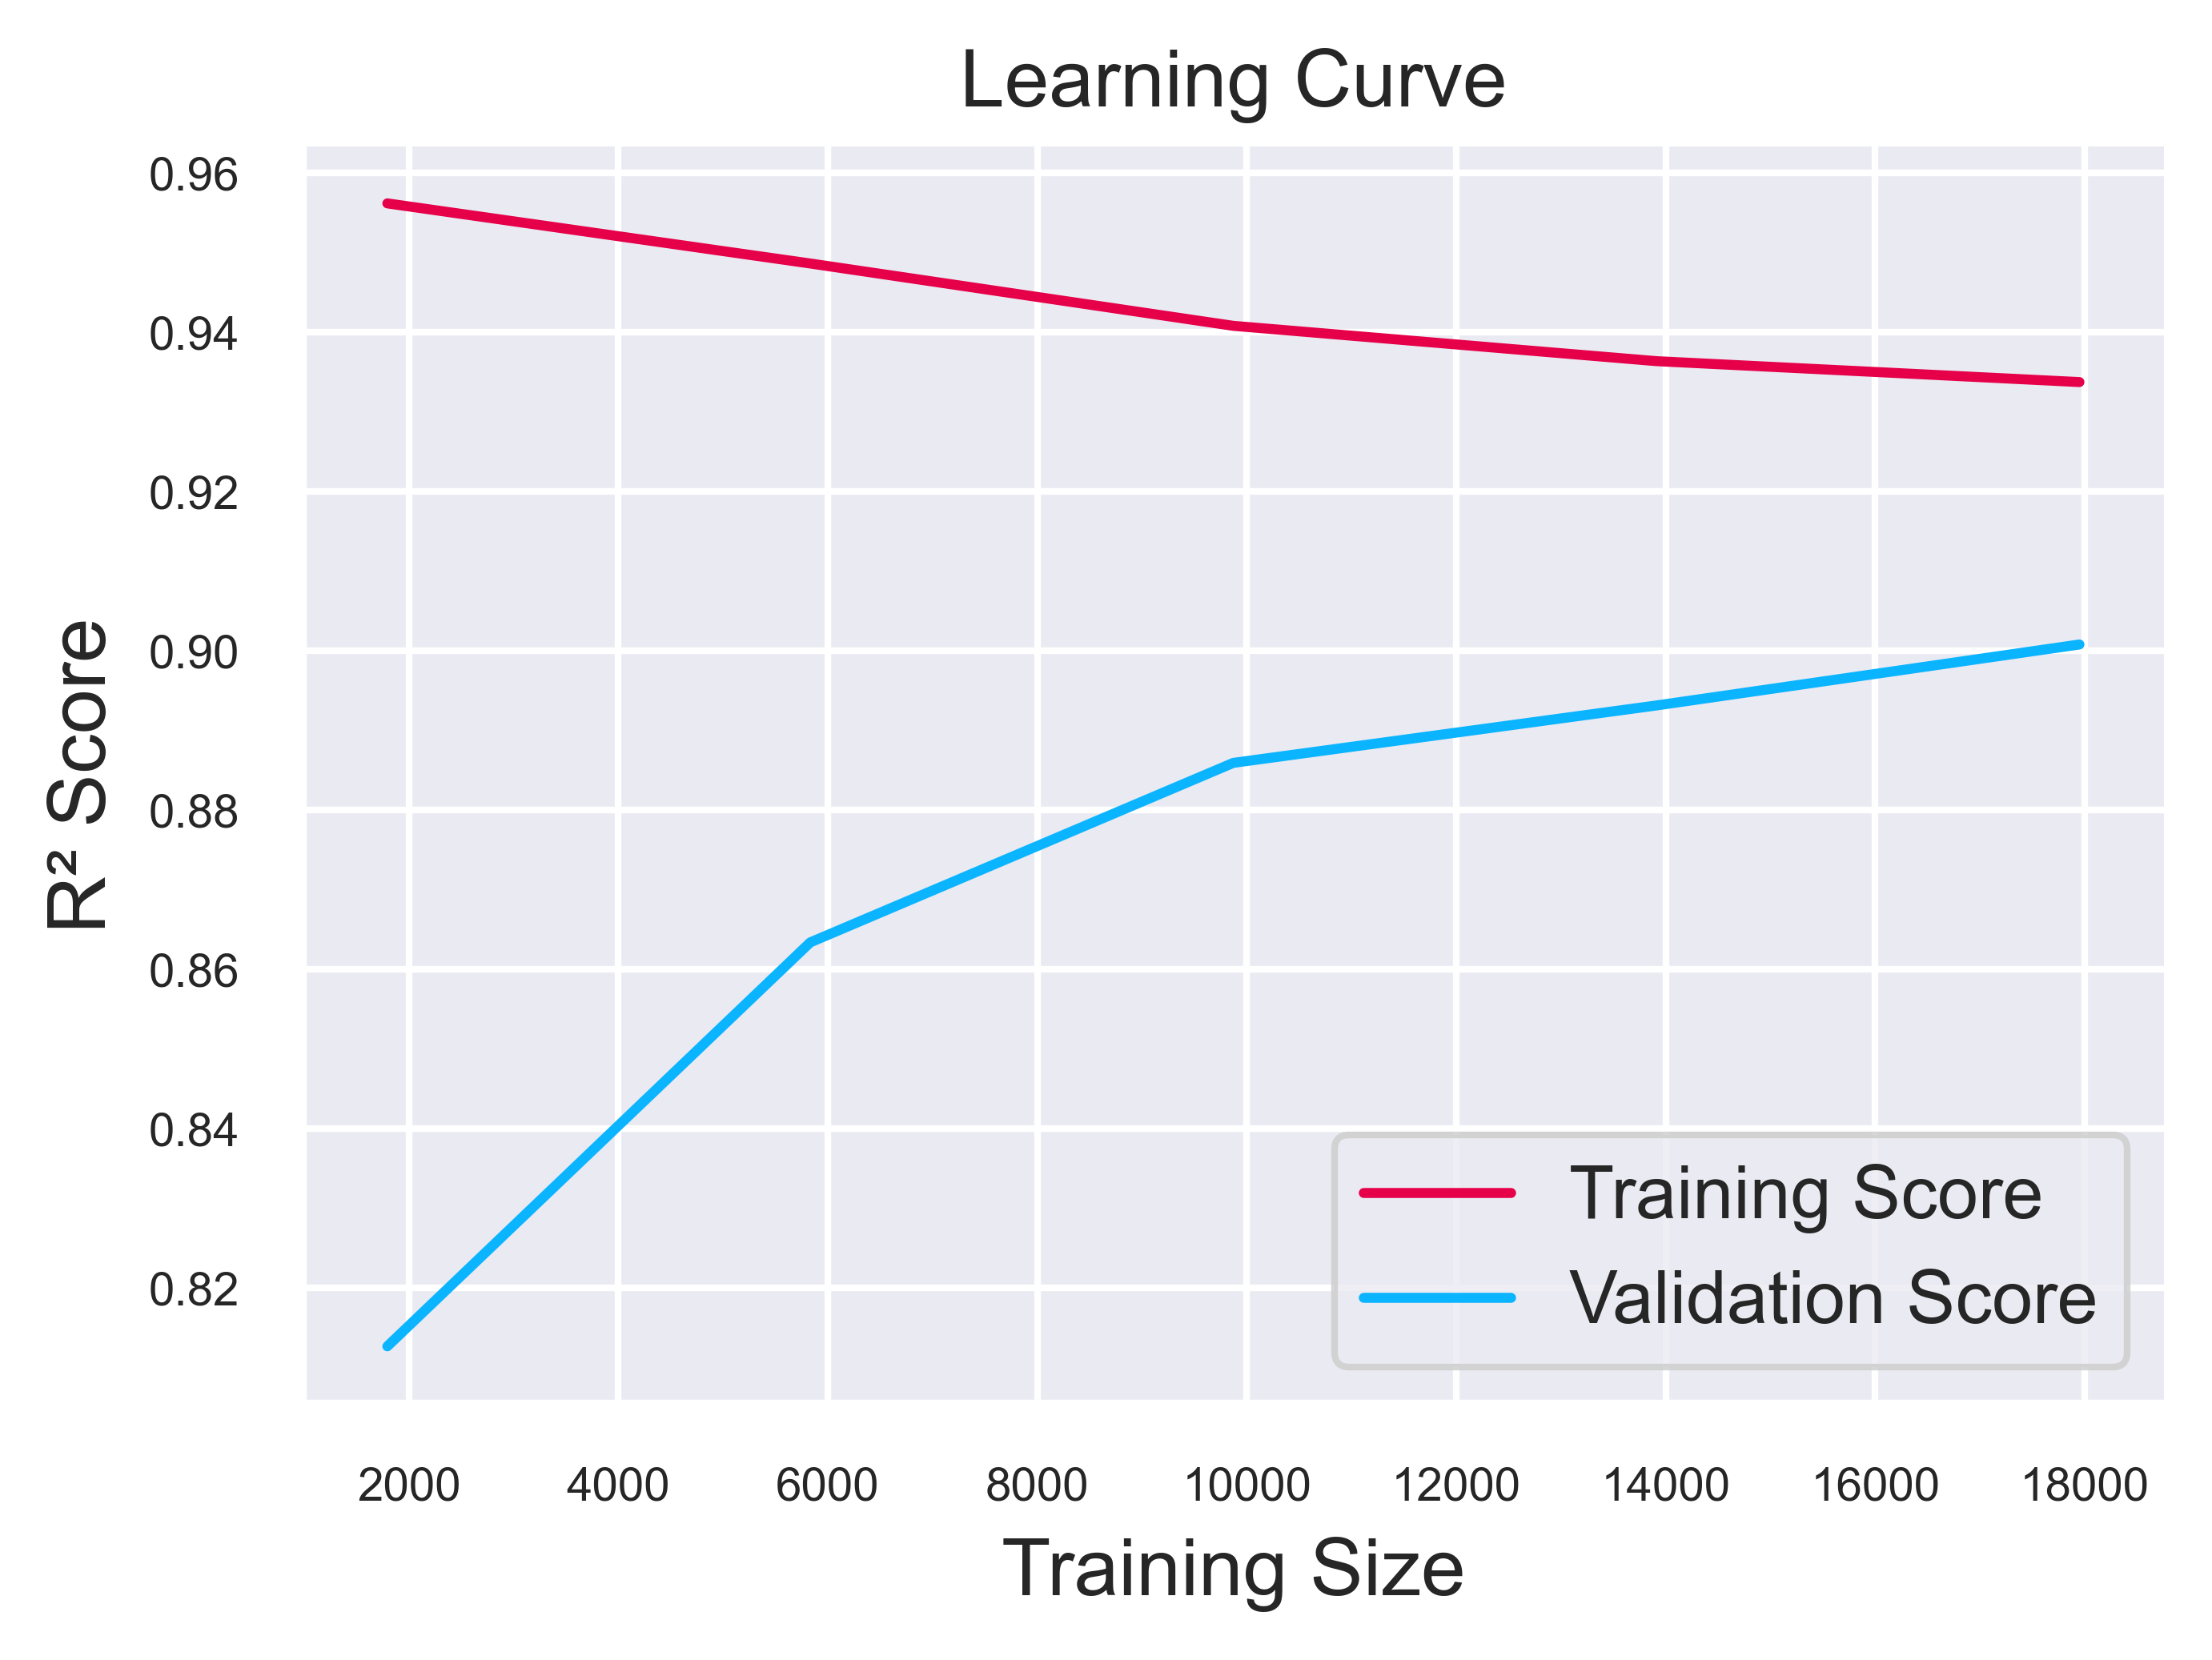

In [205]:
train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('R² Score')
plt.title('Learning Curve')
plt.legend();